# Загрузка данных и предобработка

In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns 
import statsmodels.stats.proportion as proportion
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm
import timeit
from scipy import stats
from sqlalchemy import create_engine
import math
from datetime import date, datetime, timedelta
import time
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import warnings
warnings.filterwarnings("ignore")

from credential import dwh_secret,antares_secret 


def get_engine(db_name):
    if db_name == antares_secret['dbname']:
        user = antares_secret['user']
        password = antares_secret['password']
        host = antares_secret['host']
        engine = create_engine(f'postgresql://{user}:{password}@{host}:5432/{db_name}')
    elif db_name == dwh_secret['dbname']:
        user = dwh_secret['user'] 
        password = dwh_secret['password']
        host = dwh_secret['host']
        engine = create_engine(f'postgresql://{user}:{password}@{host}:5432/{db_name}')
    return engine
        



def execute(SQL, db_name = 'dwh'):
    start_time = time.time()  # запоминаем время начала выполнения функции
    engine = get_engine(db_name)
    Session = sessionmaker(bind=engine)  # sessions factory ()
    with Session() as session: # open session
        result = session.execute(text(SQL))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        
    end_time = time.time()  # запоминаем время окончания выполнения функции
    execution_time = end_time - start_time  # вычисляем время выполнения   
    
    print(f"Время выполнения функции: {execution_time} секунд")
    return df
    

In [3]:
start_date = datetime.strptime("2024-04-11", "%Y-%m-%d")
end_date = datetime.strptime("2024-04-25", "%Y-%m-%d")
query = f''' WITH users_ab AS ( 
                SELECT 
                event_json->>'yappy_device_id' AS yappy_device_uuid,
                appmetrica_device_id,
                event_json->>'group' AS experiment_group
                FROM appmetrica.fct_ods_appm_export_events t1 
                WHERE event_date_msk BETWEEN '{start_date}' AND '{end_date}'
                AND event_name='experiment' 
                AND event_json->>'group' IN ('lenta__rltpw_control_A', 'lenta__rltpw_test_B')
                GROUP BY 1,2,3
        ),

        users_w_experiment_empty AS (
                SELECT 
                DISTINCT 
                event_json->>'yappy_device_id' AS yappy_device_uuid
                FROM appmetrica.fct_ods_appm_export_events t1 
                WHERE event_date_msk BETWEEN '{start_date}' AND '{end_date}'
                AND event_name='experiment_empty' 
                GROUP BY 1

                ),

        ab_users_dublicate AS  (---------Дедупликация ------------------
                SELECT yappy_device_uuid
                FROM users_ab
                GROUP BY 1
                HAVING count(yappy_device_uuid)>1
        ),

        ab_users_dublicate_2 AS ( --------Дедупликация -----------
                SELECT yappy_device_uuid
                FROM users_ab
                GROUP BY 1
                HAVING count(appmetrica_device_id)>1

        ),

        ab_users_wo_dublicate AS  (-------Убираем пользователей, которые попали в несколько групп и получили событие experiment_empty
                SELECT 
                t1.*,
                CASE WHEN t3.yappy_device_uuid IS NULL THEN 0 ELSE 1 END AS empty_user
                FROM users_ab AS t1
                LEFT JOIN ab_users_dublicate AS t2
                ON t1.yappy_device_uuid=t2.yappy_device_uuid
                LEFT JOIN users_w_experiment_empty  AS t3
                ON t1.yappy_device_uuid=t3.yappy_device_uuid
                LEFT JOIN ab_users_dublicate_2  AS t4
                ON t1.yappy_device_uuid=t4.yappy_device_uuid
                WHERE t2.yappy_device_uuid IS NULL AND t4.yappy_device_uuid IS NULL 
        )


        SELECT 

        t1.date_msk,
        t1.device_id,
        t3.empty_user,
        t1.profile_type,
        t1.bot_flag,
        t1.os_name,
        t1.score_str,
        t2.os_version,
        t2.app_version_name,
        t2.device_manufacturer,
        t2.device_model,
        t2.country_type,
        t3.experiment_group,
        t1.watchtime,
        t1.broadcast
        FROM
        (SELECT
            date_msk,
            lower(device_id) AS device_id,
            CASE WHEN profile_uuid IS NOT NULL THEN 'Зарег' ELSE 'Незарег' END profile_type,
            client AS os_name,
            score_str,
            bot_flag,
            sum(ttl_depth_ms)/1000 AS watchtime,
            sum(cnt_video) AS broadcast
            FROM dds.fct_dds_backend_streams_watchtime_by_user
            WHERE reference=1 AND date_msk BETWEEN '{start_date}' AND '{end_date}'
            GROUP BY 1,2,3,4,5,6
        ) AS t1

        LEFT JOIN (SELECT 
            lower(yappy_device_uuid::TEXT) AS yappy_device_uuid,
            max(device_model) AS device_model,
            max(device_manufacturer) AS device_manufacturer,
            max(country_type) AS country_type,
            max(app_version_name) AS app_version_name,
            max(os_version) AS os_version
            FROM dds.fct_dds_clear_appm_events
            WHERE event_date_msk BETWEEN '{start_date}' AND '{end_date}'
            AND event_name IN ('video_visible','video_watch','video_watched','video_add_like','video_add_comment','video_share')
            AND reference='tape'
            GROUP BY 1
            ) t2
        ON t1.device_id=t2.yappy_device_uuid


        LEFT JOIN (SELECT lower(yappy_device_uuid::TEXT) AS yappy_device_uuid,empty_user,experiment_group 
                   FROM  ab_users_wo_dublicate
                   ) AS  t3
        ON t1.device_id=t3.yappy_device_uuid
'''

df = execute(query,db_name='dwh')
df['date_msk']=df['date_msk'].astype('datetime64[ns]')   
df['watchtime']=df['watchtime'].astype('float')
df['broadcast']=df['broadcast'].astype('int')
df.info()

Время выполнения функции: 42.980483293533325 секунд
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380738 entries, 0 to 1380737
Data columns (total 15 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date_msk             1380738 non-null  datetime64[ns]
 1   device_id            1380738 non-null  object        
 2   empty_user           676870 non-null   float64       
 3   profile_type         1380738 non-null  object        
 4   bot_flag             1380738 non-null  int64         
 5   os_name              1380738 non-null  int64         
 6   score_str            974992 non-null   object        
 7   os_version           1344557 non-null  object        
 8   app_version_name     1344557 non-null  object        
 9   device_manufacturer  1344557 non-null  object        
 10  device_model         1344557 non-null  object        
 11  country_type         1344557 non-null  object        
 12  expe

In [4]:
query_retention =f"""
            SELECT 
                device_id,  
                first_date_in_app,
                client,
                count(CASE WHEN retention_day=0 THEN device_id END) AS d_0,
                count(CASE WHEN retention_day=1 THEN device_id END) AS d_1,
                count(CASE WHEN retention_day=3 THEN device_id END) AS d_3
                FROM(
                    SELECT
                    t2.event_date_msk as first_date_in_app, --дата нулевого дня
                    t1.date_msk, 
                    t1.client,
                    t1.date_msk-t2.event_date_msk as retention_day,  -- число дней, когда пользователь вернулся
                    t1.device_id
                    FROM (SELECT date_msk,lower(device_id::TEXT) AS device_id,client,sum(cnt_video) AS cnt_video FROM dds.fct_dds_backend_streams_watchtime_by_user
                          WHERE date_msk BETWEEN '{start_date}' AND '{end_date}' AND reference=1
                          GROUP BY 1,2,3
                          ) AS t1
                    INNER JOIN (SELECT event_date_msk,lower(yappy_device_uuid::TEXT) AS yappy_device_uuid FROM dds.fct_dds_appm_first_event_device_uuid_app_open
                                WHERE event_date_msk BETWEEN '{start_date}' AND '{end_date}'
                                )AS t2
                    ON t1.device_id=t2.yappy_device_uuid
                    )t1
                GROUP BY 1,2,3
                """


df_retention = execute(query_retention,db_name='dwh')
df_retention['first_date_in_app'] = df_retention['first_date_in_app'].astype('datetime64[ns]')
df_retention.info()

Время выполнения функции: 2.2712483406066895 секунд
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426675 entries, 0 to 426674
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   device_id          426675 non-null  object        
 1   first_date_in_app  426675 non-null  datetime64[ns]
 2   client             426675 non-null  int64         
 3   d_0                426675 non-null  int64         
 4   d_1                426675 non-null  int64         
 5   d_3                426675 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 19.5+ MB


In [ ]:
query_retention = 

In [5]:
df_retention.groupby('first_date_in_app')['d_0'].sum()

first_date_in_app
2024-04-11    27948
2024-04-12    28083
2024-04-13    28744
2024-04-14    31402
2024-04-15    25722
2024-04-16    27926
2024-04-17    27595
2024-04-18    28924
2024-04-19    29039
2024-04-20    27588
2024-04-21    27961
2024-04-22    25737
2024-04-23    28203
2024-04-24    28249
2024-04-25    28863
Name: d_0, dtype: int64

In [6]:
df_merge = pd.merge(df,df_retention,on='device_id',how='left')
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380738 entries, 0 to 1380737
Data columns (total 20 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date_msk             1380738 non-null  datetime64[ns]
 1   device_id            1380738 non-null  object        
 2   empty_user           676870 non-null   float64       
 3   profile_type         1380738 non-null  object        
 4   bot_flag             1380738 non-null  int64         
 5   os_name              1380738 non-null  int64         
 6   score_str            974992 non-null   object        
 7   os_version           1344557 non-null  object        
 8   app_version_name     1344557 non-null  object        
 9   device_manufacturer  1344557 non-null  object        
 10  device_model         1344557 non-null  object        
 11  country_type         1344557 non-null  object        
 12  experiment_group     676870 non-null   object        
 1

In [7]:
df_merge.groupby('first_date_in_app')['d_0'].sum()

first_date_in_app
2024-04-11    55016.0
2024-04-12    55813.0
2024-04-13    56024.0
2024-04-14    59238.0
2024-04-15    49344.0
2024-04-16    52695.0
2024-04-17    52440.0
2024-04-18    52115.0
2024-04-19    49071.0
2024-04-20    42563.0
2024-04-21    41011.0
2024-04-22    37090.0
2024-04-23    38718.0
2024-04-24    35213.0
2024-04-25    31362.0
Name: d_0, dtype: float64

In [8]:
df_merge.groupby(['date_msk','experiment_group'])['device_id'].nunique()

date_msk    experiment_group      
2024-04-11  lenta__rltpw_control_A    13854
            lenta__rltpw_test_B       13908
2024-04-12  lenta__rltpw_control_A    16811
            lenta__rltpw_test_B       16903
2024-04-13  lenta__rltpw_control_A    17272
            lenta__rltpw_test_B       17355
2024-04-14  lenta__rltpw_control_A    19898
            lenta__rltpw_test_B       19819
2024-04-15  lenta__rltpw_control_A    20369
            lenta__rltpw_test_B       20380
2024-04-16  lenta__rltpw_control_A    19469
            lenta__rltpw_test_B       19543
2024-04-17  lenta__rltpw_control_A    26376
            lenta__rltpw_test_B       26345
2024-04-18  lenta__rltpw_control_A    37938
            lenta__rltpw_test_B       38207
2024-04-19  lenta__rltpw_control_A    34509
            lenta__rltpw_test_B       34680
2024-04-20  lenta__rltpw_control_A    22863
            lenta__rltpw_test_B       22656
2024-04-21  lenta__rltpw_control_A    19651
            lenta__rltpw_test_B       194

In [9]:
df_merge['first_date_in_app'].fillna('2000-01-01',inplace=True) ## Вместо null вбил рандомную старую дату
df_merge['d_0'].fillna(0,inplace=True)
df_merge['d_1'].fillna(0,inplace=True)
df_merge['d_3'].fillna(0,inplace=True)

In [10]:
df_merge[df_merge['first_date_in_app']!='2000-01-01'].groupby('date_msk')['device_id'].nunique().reset_index()

,date_msk,device_id
0,2024-04-11,28038
1,2024-04-12,33510
2,2024-04-13,38467
3,2024-04-14,45178
4,2024-04-15,36499
5,2024-04-16,39521
6,2024-04-17,49406
7,2024-04-18,52505
8,2024-04-19,53315
9,2024-04-20,51946


# Рассмотрим отдельно сабленты

In [ ]:
with connection_2.cursor() as cursor:
        query ='''  SELECT 
                    event_created_at::date AS date_msk,
                    device_id,
                    video_uuid,
                    sublenta,
                    CASE WHEN profile_uuid IS NULL THEN 'Незарег' ELSE 'Зарег' END profile_type                
                    FROM svr_streams ss 
                    WHERE reference=1 AND event_created_at::date BETWEEN '2024-02-03' and '2024-02-09' AND sublenta='start_select'
                    GROUP BY 1,2,3,4,5
                    '''
        print("Время выполнения запроса:",timeit.timeit(lambda: cursor.execute(query), number=1),"секунд")
        #cursor.execute(query)
        df_svr=cursor.fetchall() 
cursor.close()        

In [ ]:
columns=[]
for i in cursor.description:
    columns.append(i[0])
df_svr=pd.DataFrame(df_svr,columns=columns)      
df_svr['date_msk'] = df_svr['date_msk'].astype('datetime64[ns]')

In [ ]:
unique_videos = df_svr.drop_duplicates('video_uuid')[['video_uuid']]
unique_videos

In [ ]:
with connection.cursor() as cursor:    
        query =''' SELECT 
                    event_created_at_msk::date AS date_msk,
                    lower(device_id) AS device_id,
                    object_uuid,
                    client,
                    DEPTH AS watchtime
                    FROM atik_prod.ods_streams
                    WHERE event_created_at_msk BETWEEN '2024-02-03' AND '2024-02-09' AND profile_uuid IS NULL AND client IN (0,1)
                    '''
        print("Время выполнения запроса:",timeit.timeit(lambda: cursor.execute(query), number=1),"секунд")
        #cursor.execute(query)
        df_streams=cursor.fetchall()

connection_2.commit()        
cursor.close()        

In [ ]:
columns=[]
for i in cursor.description:
    columns.append(i[0])
df_streams=pd.DataFrame(df_streams,columns=columns)      
df_streams['date_msk'] = df_streams['date_msk'].astype('datetime64[ns]')

In [ ]:
df_streams_2=df_streams.copy()

In [ ]:
df_start_select = pd.merge(df_streams_2,unique_videos,left_on=['object_uuid'],right_on=['video_uuid'], how='inner')
df_start_select_agg = df_start_select.groupby(['date_msk','device_id','client'])['watchtime'].sum().reset_index()


In [ ]:
# Пользователям
df_experiment = df[(df['experiment_group'].notna()) & (df['bot_flag']==0) & (df['empty_user']==0)][['device_id','experiment_group']]
df_experiment = df_experiment.drop_duplicates(['device_id','experiment_group'])                                                                                                   
df_experiment

#

In [ ]:
df_start_select_agg_megre = pd.merge(df_start_select_agg,df_experiment,how='left')[['date_msk','device_id','client','watchtime','experiment_group']]
df_start_select_agg_megre = df_start_select_agg_megre[df_start_select_agg_megre['experiment_group'].notna()]

In [ ]:
df_start_select_agg_megre['device_id'].nunique()

In [ ]:
df_merge_svr_streams_2_agg = df_start_select_agg_megre.groupby(['date_msk','experiment_group'])['watchtime'].mean().reset_index()


df_merge_svr_streams_2_agg_control_D = df_merge_svr_streams_2_agg[(df_merge_svr_streams_2_agg['experiment_group']=='lenta_start_select_control_D')].sort_values(by='date_msk')
df_merge_svr_streams_2_agg_test_A = df_merge_svr_streams_2_agg[(df_merge_svr_streams_2_agg['experiment_group']=='lenta_start_select_test_A')].sort_values(by='date_msk')
df_merge_svr_streams_2_agg_test_B = df_merge_svr_streams_2_agg[(df_merge_svr_streams_2_agg['experiment_group']=='lenta_start_select_test_B')].sort_values(by='date_msk')
df_merge_svr_streams_2_agg_test_C = df_merge_svr_streams_2_agg[(df_merge_svr_streams_2_agg['experiment_group']=='lenta_start_select_test_C')].sort_values(by='date_msk')


plt.figure(figsize=(20,8))
plt.plot(df_merge_svr_streams_2_agg_control_D['date_msk'], df_merge_svr_streams_2_agg_control_D['watchtime'], label='watchtime control', linewidth=3)
plt.plot(df_merge_svr_streams_2_agg_test_A['date_msk'], df_merge_svr_streams_2_agg_test_A['watchtime'], label='watchtime test A', linewidth=3)
plt.plot(df_merge_svr_streams_2_agg_test_B['date_msk'], df_merge_svr_streams_2_agg_test_B['watchtime'], label='watchtime test B', linewidth=3)
plt.plot(df_merge_svr_streams_2_agg_test_C['date_msk'], df_merge_svr_streams_2_agg_test_C['watchtime'], label='watchtime test D', linewidth=3)


plt.title('График watchtime сабленты start select по группам')
plt.legend()
plt.show()

# Вводные параметры 

In [20]:
control_group = 'lenta__rltpw_control_A'
test_group_1 = 'lenta__rltpw_test_B'

num_of_bucket = 2  # Число групп

begin_date = datetime.strptime('2024-04-18', '%Y-%m-%d')
end_date = datetime.strptime('2024-04-25', '%Y-%m-%d')
cuped_date = begin_date - timedelta(days = 7) 

# Даты для retention 
day_retention_1_day = datetime.strptime('2024-04-23', '%Y-%m-%d') # крайний день интервала указывается 
day_retention_3_day = datetime.strptime('2024-04-22', '%Y-%m-%d') # минус 3 дня от крайнего дня 

# Незареги

In [207]:
df_merge = df_merge[df_merge['date_msk']!='2024-04-24']

In [208]:
df_unregister = df_merge[(df_merge['date_msk'] >= begin_date) & (df_merge['date_msk'] <= end_date) & (df_merge['empty_user'] == 0) & (df_merge['bot_flag'] == 0) & (~df_merge['score_str'].isin(['mid', 'high'])) & (df_merge['profile_type'] == 'Незарег') & (df_merge['app_version_name'] != '1.49.0')]
df_unregister_agg = df_unregister.groupby(['date_msk','experiment_group']).agg({'watchtime':'mean','broadcast':'mean'}).reset_index()
df_unregister_agg

,date_msk,experiment_group,watchtime,broadcast
0,2024-04-18,lenta__rltpw_control_A,89.749957,14.478808
1,2024-04-18,lenta__rltpw_test_B,84.327407,16.175332
2,2024-04-19,lenta__rltpw_control_A,93.686760,15.269195
3,2024-04-19,lenta__rltpw_test_B,93.729720,17.158627
4,2024-04-20,lenta__rltpw_control_A,103.652336,16.334194
5,2024-04-20,lenta__rltpw_test_B,101.055521,15.890853
6,2024-04-21,lenta__rltpw_control_A,99.837114,14.970309
7,2024-04-21,lenta__rltpw_test_B,89.871301,14.762190
8,2024-04-22,lenta__rltpw_control_A,80.585796,13.690476
9,2024-04-22,lenta__rltpw_test_B,77.728466,11.799718


In [209]:
df_unregister.groupby('experiment_group')['watchtime'].mean()

experiment_group
lenta__rltpw_control_A    89.832234
lenta__rltpw_test_B       87.542224
Name: watchtime, dtype: float64

In [210]:
df_unregister['date_msk'].unique()

<DatetimeArray>
['2024-04-22 00:00:00', '2024-04-25 00:00:00', '2024-04-19 00:00:00',
 '2024-04-18 00:00:00', '2024-04-21 00:00:00', '2024-04-23 00:00:00',
 '2024-04-20 00:00:00']
Length: 7, dtype: datetime64[ns]

In [211]:
t1 = df_unregister.groupby('device_id')['watchtime'].sum().reset_index()
t1['watchtime'].var()

199469.14868039507

In [212]:
df_unregister.groupby('date_msk')['device_id'].nunique()

date_msk
2024-04-18    12846
2024-04-19    10888
2024-04-20     5313
2024-04-21     5028
2024-04-22     4227
2024-04-23     4283
2024-04-25     4808
Name: device_id, dtype: int64

In [213]:
df_unregister_first_date = df_unregister[(df_unregister['first_date_in_app']!='2000-01-01') & (df_unregister['first_date_in_app']<=day_retention_1_day) & (df_unregister['first_date_in_app']>=begin_date)]
df_unregister_first_date['first_date_in_app'].unique()

df_unregister_first_date_agg = df_unregister_first_date.groupby(['first_date_in_app','experiment_group']).agg({'d_0':'sum','d_1':'sum'}).reset_index()
df_unregister_first_date_agg['conv'] = df_unregister_first_date_agg['d_1'] / df_unregister_first_date_agg['d_0']
df_unregister_first_date_agg

,first_date_in_app,experiment_group,d_0,d_1,conv
0,2024-04-18,lenta__rltpw_control_A,3722.0,612.0,0.164428
1,2024-04-18,lenta__rltpw_test_B,3686.0,595.0,0.161422
2,2024-04-19,lenta__rltpw_control_A,2906.0,351.0,0.120785
3,2024-04-19,lenta__rltpw_test_B,2999.0,364.0,0.121374
4,2024-04-20,lenta__rltpw_control_A,577.0,144.0,0.249567
5,2024-04-20,lenta__rltpw_test_B,515.0,130.0,0.252427
6,2024-04-21,lenta__rltpw_control_A,467.0,85.0,0.182013
7,2024-04-21,lenta__rltpw_test_B,509.0,116.0,0.227898
8,2024-04-22,lenta__rltpw_control_A,393.0,71.0,0.180662
9,2024-04-22,lenta__rltpw_test_B,373.0,86.0,0.230563


In [214]:
df_unregister_third_date = df_unregister[(df_unregister['first_date_in_app']!='2000-01-01') & (df_unregister['first_date_in_app']<=day_retention_3_day)]
df_unregister_third_date['first_date_in_app'].unique()

df_unregister_third_date_agg = df_unregister_third_date.groupby(['first_date_in_app','experiment_group']).agg({'d_0':'sum','d_3':'sum'}).reset_index()
df_unregister_third_date_agg['conv'] = df_unregister_third_date_agg['d_3'] / df_unregister_third_date_agg['d_0']
df_unregister_third_date_agg

,first_date_in_app,experiment_group,d_0,d_3,conv
0,2024-04-11,lenta__rltpw_control_A,141.0,30.0,0.212766
1,2024-04-11,lenta__rltpw_test_B,131.0,24.0,0.183206
2,2024-04-12,lenta__rltpw_control_A,140.0,24.0,0.171429
3,2024-04-12,lenta__rltpw_test_B,141.0,21.0,0.148936
4,2024-04-13,lenta__rltpw_control_A,190.0,25.0,0.131579
5,2024-04-13,lenta__rltpw_test_B,153.0,23.0,0.150327
6,2024-04-14,lenta__rltpw_control_A,225.0,59.0,0.262222
7,2024-04-14,lenta__rltpw_test_B,277.0,77.0,0.277978
8,2024-04-15,lenta__rltpw_control_A,174.0,109.0,0.626437
9,2024-04-15,lenta__rltpw_test_B,162.0,123.0,0.759259


## Метрики в динамике по группам экспериментам 

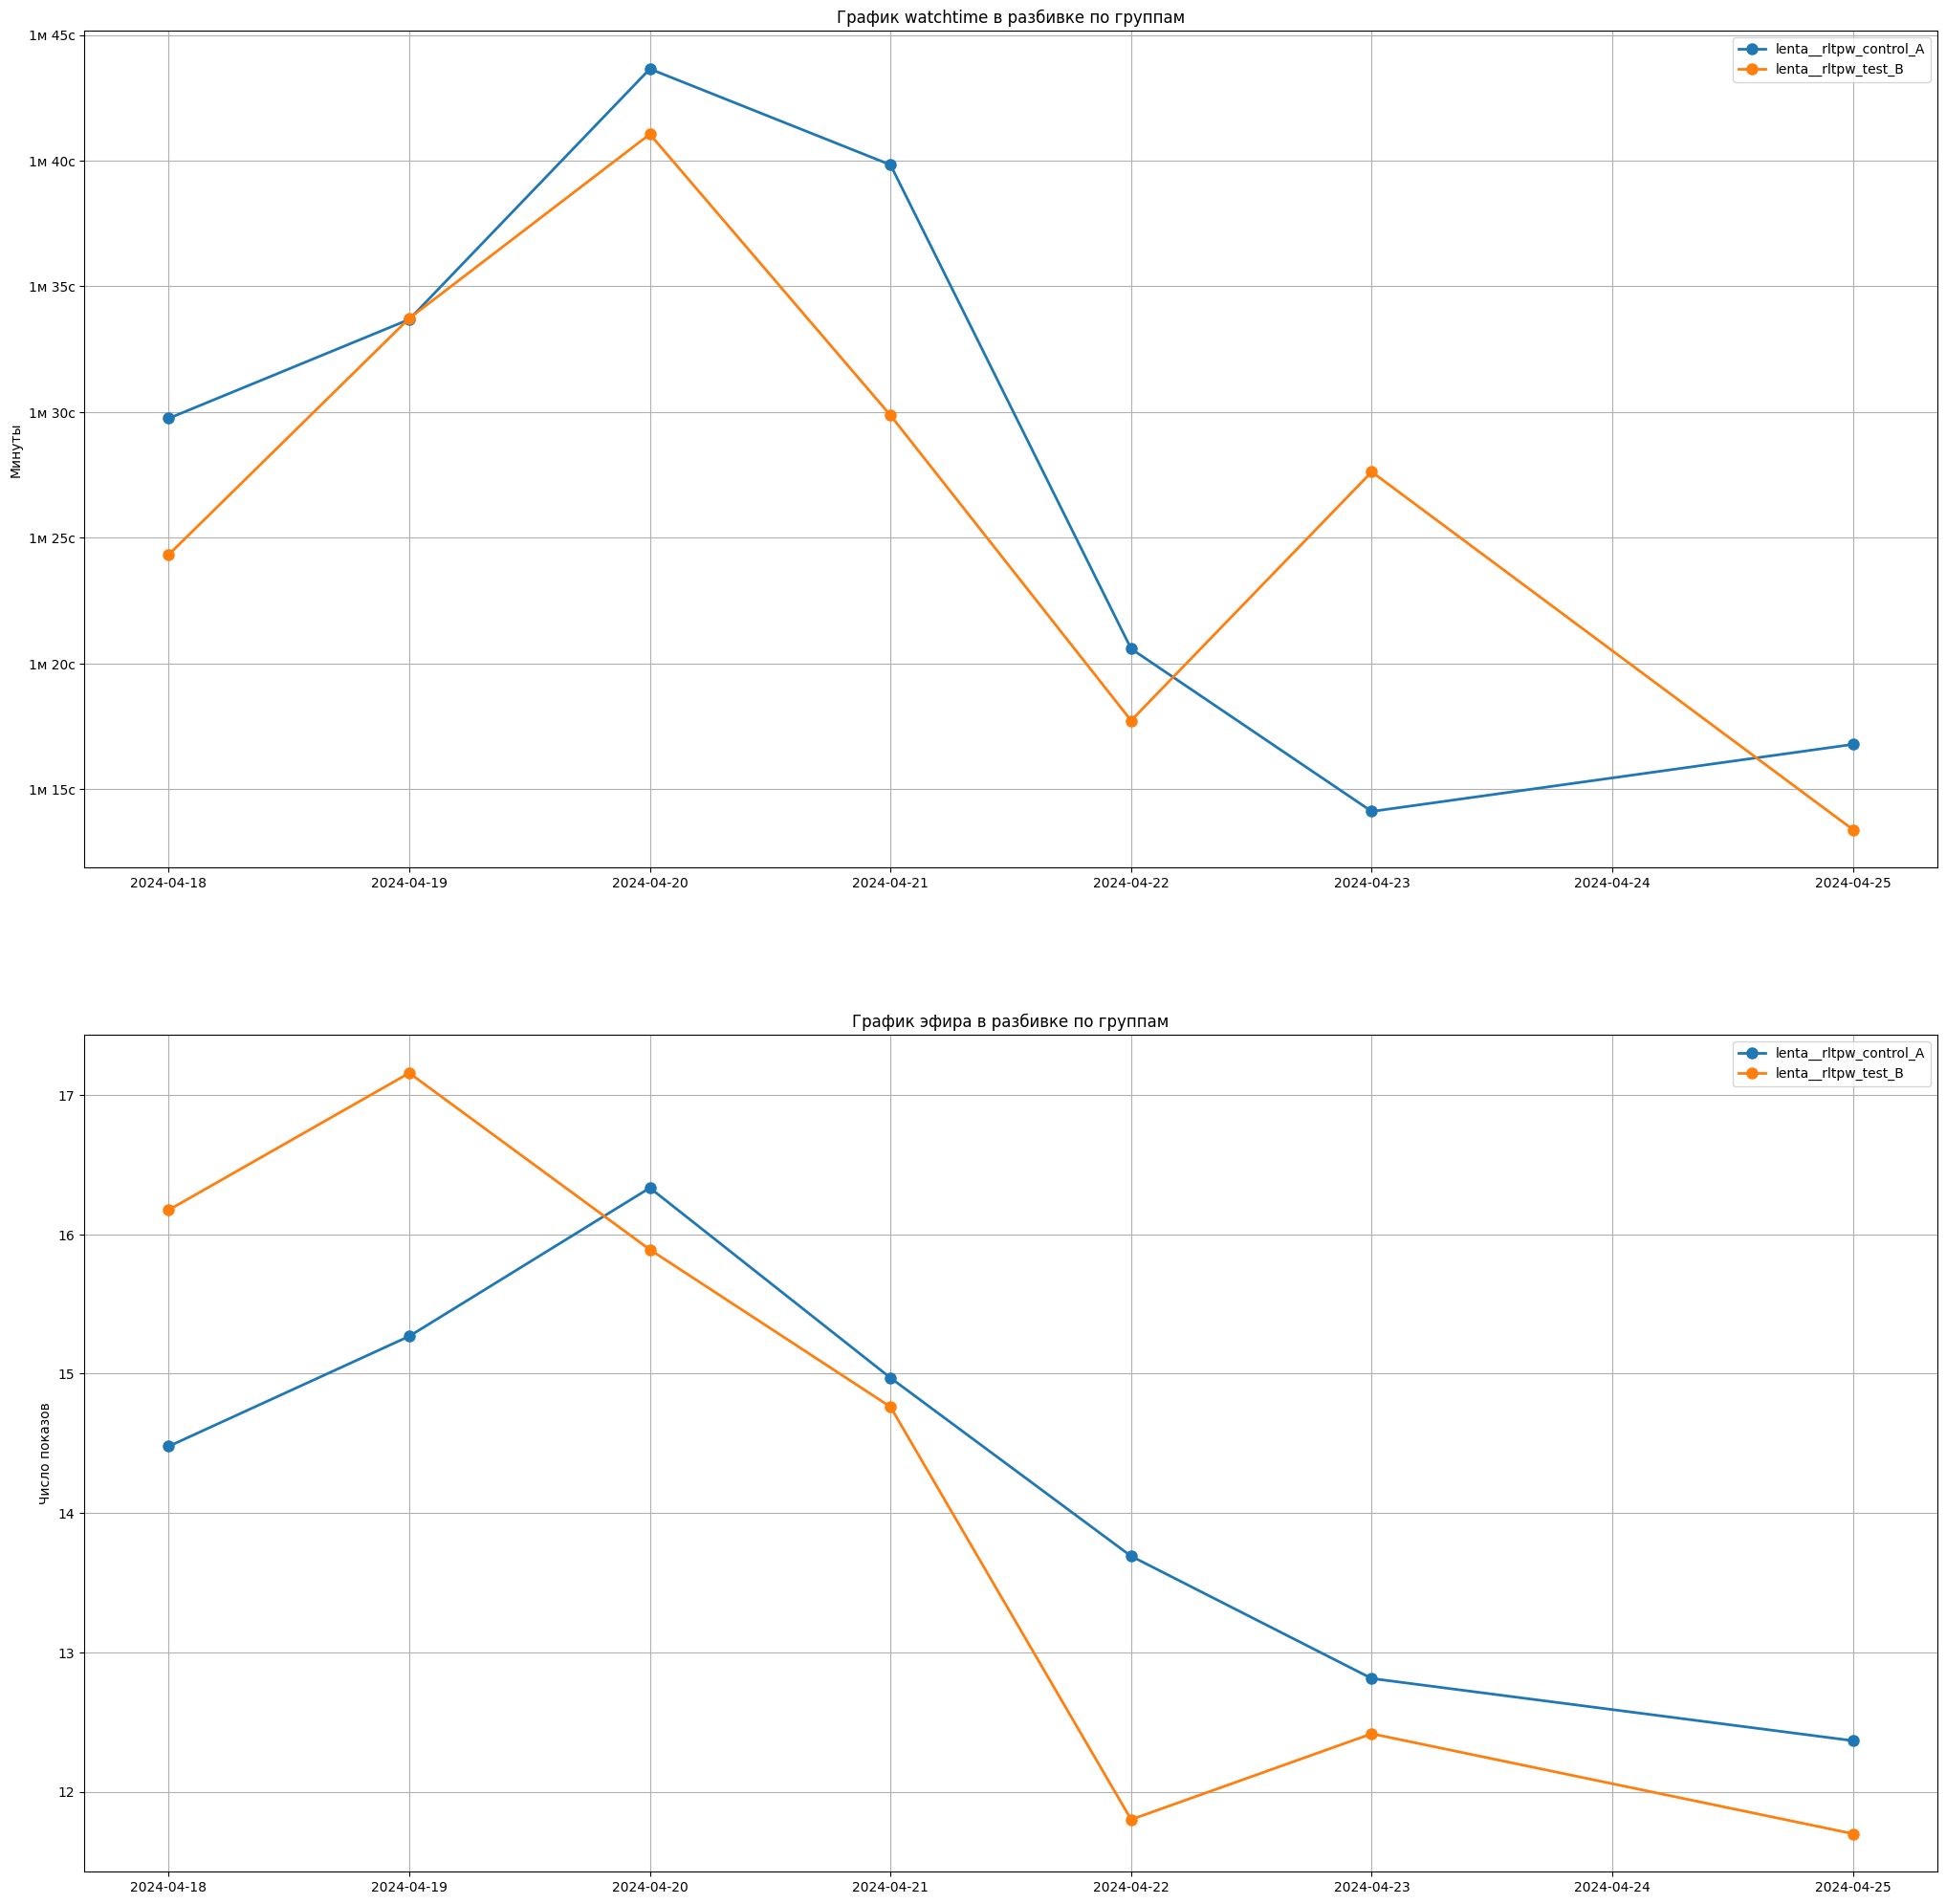

In [215]:
fix,axes = plt.subplots(2,1,figsize=(25,25))

def format_func(value, tick_number):
    minutes = int(value) // 60
    seconds = int(value) % 60
    return f"{minutes}м {seconds}с"

# цикл по всем значениям experiment group
for i in df_unregister_agg['experiment_group'].unique():
    t = df_unregister_agg[df_unregister_agg['experiment_group']==i]

    axes[0].plot(t['date_msk'], t['watchtime'], label=i,linewidth=2, marker='o', markersize=8)
    axes[1].plot(t['date_msk'], t['broadcast'], label=i,linewidth=2, marker='o', markersize=8)
    
# for i in df_unregister_first_date_agg['experiment_group'].unique():
#     t1 = df_unregister_first_date_agg[df_unregister_first_date_agg['experiment_group']==i]
#     axes[2].plot(t1['first_date_in_app'], t1['conv'], label=i,linewidth=2, marker='o', markersize=8)
    

# for i in df_unregister_third_date_agg['experiment_group'].unique():
#     t3 = df_unregister_third_date_agg[df_unregister_third_date_agg['experiment_group']==i]
#     axes[3].plot(t3['first_date_in_app'], t3['conv'], label=i,linewidth=2, marker='o', markersize=8)
    

for i in range(2):    
     axes[i].grid(True)

# Увеличиваем расстояние между графиками
plt.subplots_adjust(hspace=0.2)    


axes[0].set_title('График watchtime в разбивке по группам')
axes[0].legend()
axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
axes[0].set_ylabel('Минуты')


axes[1].set_title('График эфира в разбивке по группам')
axes[1].legend()
axes[1].set_ylabel('Число показов')

# axes[2].set_title('График RR1 по группам')
# axes[2].legend()
# axes[2].set_ylabel('RR1')
# axes[2].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

# axes[3].set_title('График RR3 по группам')
# axes[3].legend()
# axes[3].set_ylabel('RR3')
# axes[3].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

plt.show()
axes[0].figure.savefig(f"Графики по незарегам '{end_date}'.jpg")

## Тест на независимость 

In [216]:
# Функция для хи-квадра по определению независимости между выборками
def chi_independence(df, control, test_1, segment_name, part=None):
        '''H0: distributions are independent, H1: distributions are dependent '''
        for segment in segment_name:
                control1 = df[df['experiment_group'] == control][segment].value_counts()
                test1 = df[df['experiment_group'] == test_1][segment].value_counts()
                # test2 = df[df['experiment_group'] == test_2][segment].value_counts()
                # test3 = df[df['experiment_group'] == test_3][segment].value_counts()
                
                #concat = pd.concat([control1,test1,test2,test3], axis=1)
                #concat.columns = ['control_1','test_1','test_2','test_3']
                concat = pd.concat([control1,test1], axis=1)
                concat.columns = ['control','test_1']
                if part:
                    print(concat.iloc[:part])
                    stat, p_value, dof, expected = stats.chi2_contingency(concat.iloc[:part])
                else:
                    stat, p_value, dof, expected = stats.chi2_contingency(concat)

                if p_value <= 0.01:
                        print (f" {segment}- p-value: {p_value:.4f}, statistic: {stat:.4f}, dof: {dof}, dependent (reject H0)\n")
                else:
                        print (f" {segment} - p-value: {p_value:.4f}, statistic: {stat:.4f}, dof: {dof}, independent (fail to reject H0)\n")


In [217]:
chi_independence(df_unregister,
                  control_group,
                  test_group_1,
                  #test_group_2,
                  #test_group_3,
                 ["os_name","country_type","device_manufacturer","device_model","app_version_name","os_version"],
                 15
                )

         control  test_1
os_name                 
1          22748   22934
0            840     871
 os_name - p-value: 0.5852, statistic: 0.2979, dof: 1, independent (fail to reject H0)

              control  test_1
country_type                 
Россия          21776   22005
СНГ               856     843
Остальные         137     158
 country_type - p-value: 0.4572, statistic: 1.5652, dof: 2, independent (fail to reject H0)

                      control  test_1
device_manufacturer                  
Redmi                  7195.0  7264.0
Samsung                3257.0  3341.0
Realme                 2480.0  2513.0
Huawei                 1770.0  1818.0
Xiaomi                 1649.0  1645.0
Tecno                  1390.0  1359.0
POCO                   1287.0  1138.0
Infinix                 892.0   908.0
Apple                   801.0   821.0
Oppo                    456.0   544.0
Vivo                    356.0   364.0
Honor                   313.0   380.0
TECNO MOBILE LIMITED    153.0   167.0

## Тест на SRM (тест на однородность)

In [218]:
def chi_homogeneity(df, control, test_1, segment_name,number_of_groups, part=None):
    '''H0: distributions are homogeneous, H1: distributions are not homogeneous '''
    for segment in segment_name:
            control1 = df[df['experiment_group'] == control][segment].value_counts()
            test1 = df[df['experiment_group'] == test_1][segment].value_counts()
            # test2 = df[df['experiment_group'] == test_2][segment].value_counts()
            # test3 = df[df['experiment_group'] == test_3][segment].value_counts()
            concat = pd.concat([control1,test1], axis=1)
            concat.columns = ['control_1','test_1']
            concat['expected']=concat.sum(axis=1).apply(lambda x: math.ceil(x / number_of_groups))
            print(concat.iloc[:part])
            for i in concat.columns[:-1]:
                    # рассчитываем статистику
                    k = len(concat[i].iloc[:part])                                                                                             # число степеней свободы 
                    statistic = (((concat[i].iloc[:part] - concat['expected'].iloc[:part])**2)/concat['expected'].iloc[:part]).sum()           # КСП
                    # рассчитываем p-value 
                    p_value = 1 - stats.chi2.cdf(statistic, k - 1)                                                                             # вероятность получить значение выше или равное статистике
                    if p_value <= 0.01:
                            print (f" {segment}- p-value: {p_value:.4f}, statistic: {statistic:.4f}, dof: {k-1}, homogenes (reject H0)\n")
                    else:
                            print (f" {segment} - p-value: {p_value:.4f}, statistic: {statistic:.4f}, dof: {k-1}, not homogenes (fail to reject H0)\n")


In [219]:
chi_homogeneity(df_unregister,
                  control_group,
                  test_group_1,
                  # test_group_2,
                  # test_group_3,
                  ["os_name","country_type","device_manufacturer","device_model","app_version_name","os_version"],
                 num_of_bucket, # Количество групп в тесте 
                 15)

         control_1  test_1  expected
os_name                             
1            22748   22934     22841
0              840     871       856
 os_name - p-value: 0.4104, statistic: 0.6777, dof: 1, not homogenes (fail to reject H0)

 os_name - p-value: 0.4232, statistic: 0.6415, dof: 1, not homogenes (fail to reject H0)

              control_1  test_1  expected
country_type                             
Россия            21776   22005     21891
СНГ                 856     843       850
Остальные           137     158       148
 country_type - p-value: 0.4809, statistic: 1.4641, dof: 2, not homogenes (fail to reject H0)

 country_type - p-value: 0.5150, statistic: 1.3270, dof: 2, not homogenes (fail to reject H0)

                      control_1  test_1  expected
device_manufacturer                              
Redmi                    7195.0  7264.0      7230
Samsung                  3257.0  3341.0      3299
Realme                   2480.0  2513.0      2497
Huawei                

## Распределения 

In [220]:
def plot_segments_distribution(df, segment_columns, test_factor):
    for i in segment_columns:
        aggregated_data = df.groupby(by = [test_factor,i])['device_id'].count().reset_index()
        sns.catplot(x = i, 
                    y = 'device_id', 
                    hue = test_factor, # сообщаем, что хотим, чтобы разные группы имели разный цвет
                    data = aggregated_data.sort_values(by='device_id', ascending=False).iloc[:40], 
                    kind = "bar", 
                    height = 4, # задаем размер графика 
                    aspect = 1.5) # задаем ширину столбца
        plt.xticks(rotation=100)

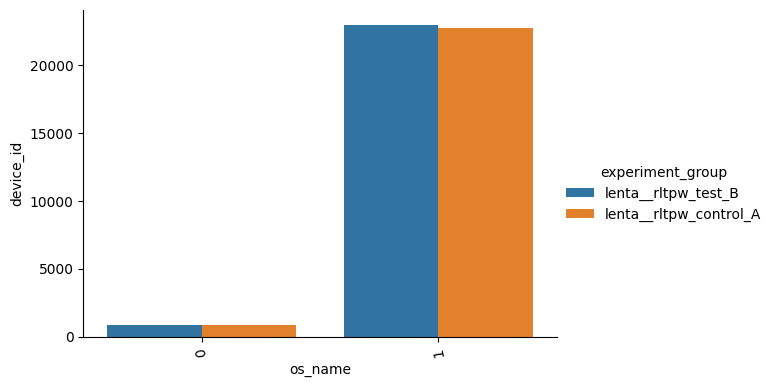

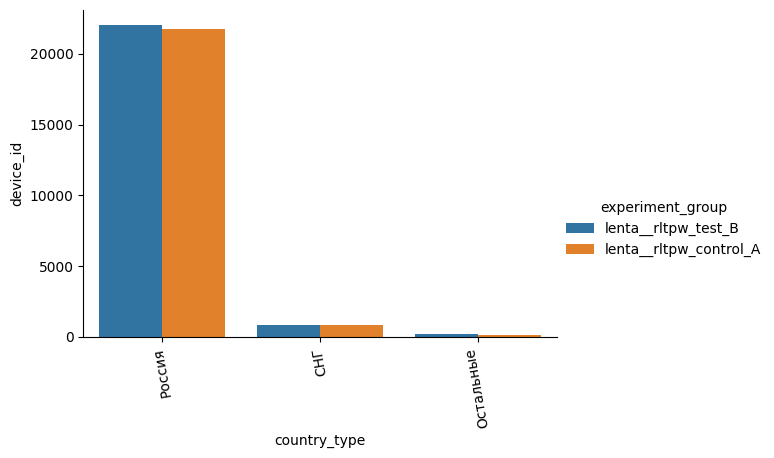

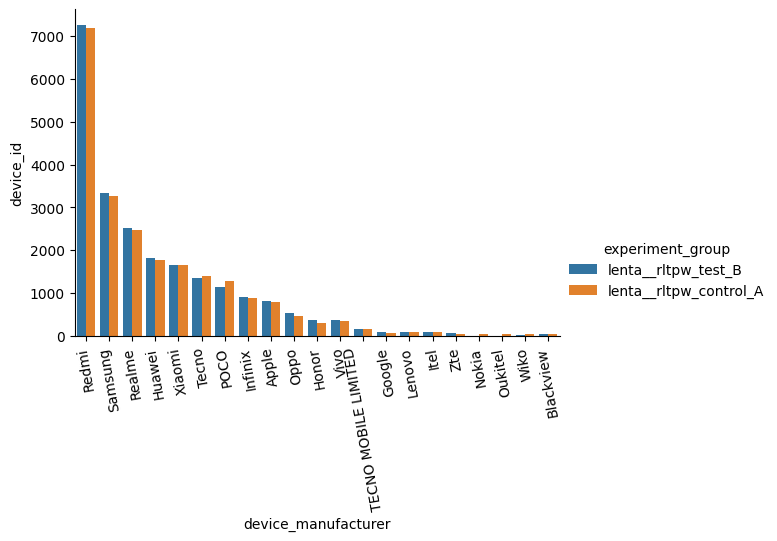

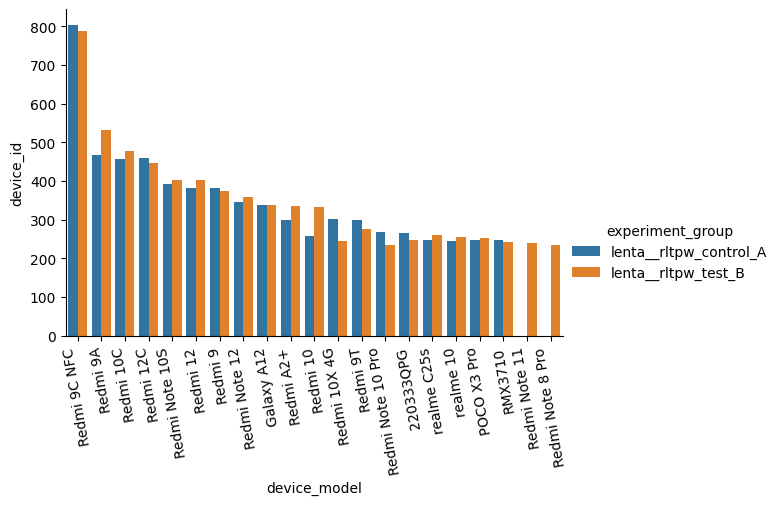

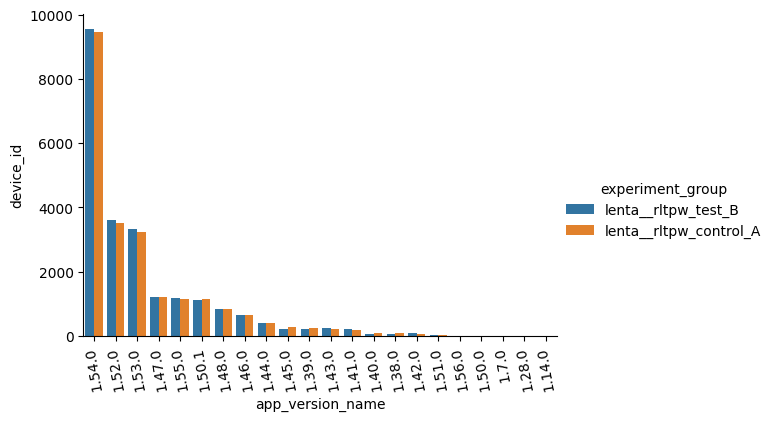

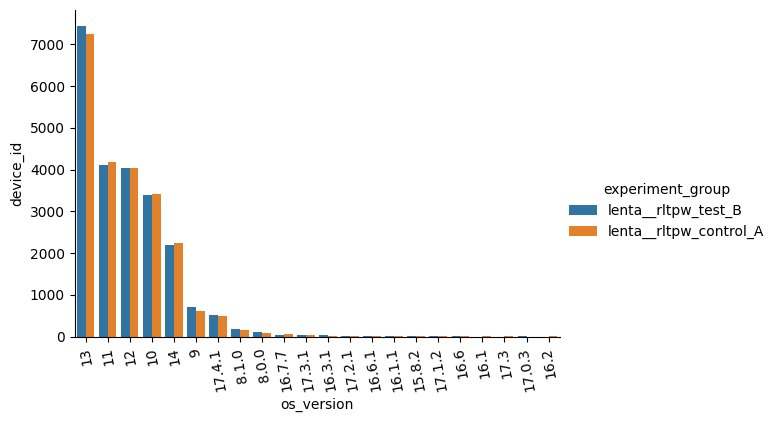

In [221]:
plot_segments_distribution(df_unregister, #датафрейм
                          ["os_name","country_type","device_manufacturer","device_model","app_version_name","os_version"],
                           "experiment_group",) #тест-фактор

## Квантильный анализ

In [222]:
df_unregister_agg = df_unregister.groupby(['device_id','os_name','os_version','app_version_name','device_manufacturer','device_model','country_type','experiment_group','first_date_in_app','d_0','d_1','d_3']).agg({'watchtime':'sum','broadcast':'sum'}).reset_index()
df_unregister_agg

,device_id,os_name,os_version,app_version_name,device_manufacturer,device_model,country_type,experiment_group,first_date_in_app,d_0,d_1,d_3,watchtime,broadcast
0,00007dfc-d1bd-3d80-b075-bc2d5b74505e,1,12,1.39.0,Realme,realme narzo 50A,Россия,lenta__rltpw_test_B,2000-01-01,0.0,0.0,0.0,0.000,1
1,0004ab23-a05a-3ac2-8f84-7aa17a87e4af,1,11,1.53.0,TECNO MOBILE LIMITED,TECNO KG5n,Россия,lenta__rltpw_test_B,2000-01-01,0.0,0.0,0.0,404.668,55
2,000564c2-a856-39ef-b90a-3dc9b5aa0672,1,10,1.52.0,Redmi,Redmi 9C NFC,Россия,lenta__rltpw_test_B,2024-04-20,1.0,0.0,0.0,210.942,45
3,0006bdec-e6f5-331c-9287-d95816d8056b,1,14,1.54.0,Samsung,Galaxy A23,Россия,lenta__rltpw_test_B,2000-01-01,0.0,0.0,0.0,0.000,1
4,000744db-d12d-4885-a3db-918e25e052c5,0,17.4.1,1.55.0,Apple,iPhone 14 Pro Max,Россия,lenta__rltpw_test_B,2024-04-20,1.0,0.0,0.0,5.001,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38084,fffa2d49-05fd-37bb-bad5-df6a3b11322b,1,13,1.54.0,Honor,HONOR 50,Россия,lenta__rltpw_control_A,2000-01-01,0.0,0.0,0.0,2.813,1
38085,fffa6b90-14fc-34e1-b247-8b2b6a9e3238,1,11,1.54.0,Xiaomi,Redmi Note 8,СНГ,lenta__rltpw_control_A,2024-04-21,1.0,1.0,0.0,5.214,4
38086,fffa7433-b0fc-36a1-b5de-8ddc20eb7eb0,1,12,1.53.0,Oppo,A17k,Россия,lenta__rltpw_test_B,2024-04-15,1.0,0.0,0.0,1.872,1
38087,fffd34c8-e927-33fa-b7b0-309221ad8b17,1,8.0.0,1.47.0,Sony,Xperia Z5 Premium,Россия,lenta__rltpw_test_B,2024-04-19,1.0,0.0,0.0,3.850,1


In [223]:
df_unregister_agg['watchtime'].var()

207362.77832750822

In [224]:
print(df_unregister_agg['device_id'].count())
print(df_unregister_agg['device_id'].nunique())

38089
38089


In [225]:
quantiles=[1,2,3,4,5,6,7,8,9,10,25,50,75,80,85,90,91,92,93,94,95,96,97,98,99]
columns = ['watchtime','broadcast']


# пустой df для хранения результатов
quantiles_data = pd.DataFrame(index=quantiles, columns=columns)

for i in columns:
    data = df_unregister_agg[i].dropna()
    quantile_values = np.percentile(data, quantiles)
    quantiles_data[i] = quantile_values

quantiles_data

,watchtime,broadcast
1,0.00000,1.0
2,0.00000,1.0
3,0.00000,1.0
4,0.00000,1.0
5,0.00000,1.0
6,0.00000,1.0
7,0.00000,1.0
8,0.00000,1.0
9,0.00000,1.0
10,0.00000,1.0


In [226]:
# Убираем 95 квантиль 
df_unregister_agg_wo_outlier = df_unregister_agg[(df_unregister_agg['watchtime']<np.percentile(df_unregister_agg['watchtime'],95))]


# df_svr_merge_agg_wo_outlier_start = df_svr_merge_agg_start[(df_svr_merge_agg_start['watchtime']<np.percentile(df_svr_merge_agg_start['watchtime'],95))]
# df_svr_merge_agg_wo_outlier_stairs = df_svr_merge_agg_stairs[(df_svr_merge_agg_stairs['watchtime']<np.percentile(df_svr_merge_agg_stairs['watchtime'],95))]
# df_svr_merge_agg_wo_outlier_actual = df_svr_merge_agg_actual[(df_svr_merge_agg_actual['watchtime']<np.percentile(df_svr_merge_agg_actual['watchtime'],95))]

In [227]:
df_unregister_agg_wo_outlier['watchtime'].var()

6810.319365544747

In [228]:
df_unregister_agg_wo_outlier['watchtime'].var()

6810.319365544747

In [229]:
grouped_df = df_unregister_agg_wo_outlier.groupby('experiment_group').agg({'device_id':'count'})
total_count = grouped_df['device_id'].sum()
grouped_df.loc['Total'] = [total_count]
grouped_df

,device_id
experiment_group,
lenta__rltpw_control_A,18042
lenta__rltpw_test_B,18142
Total,36184


In [230]:
df_unregister_agg.groupby('experiment_group')['watchtime'].mean()

experiment_group
lenta__rltpw_control_A    109.655669
lenta__rltpw_test_B       107.768820
Name: watchtime, dtype: float64

In [231]:
df_unregister_agg_wo_outlier.groupby('experiment_group')['watchtime'].mean()

experiment_group
lenta__rltpw_control_A    44.664728
lenta__rltpw_test_B       46.663666
Name: watchtime, dtype: float64

## Функция бутстрапа

In [232]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95, # уровень значимости
    alpha=0.05
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(boot_len, replace = True).values
        samples_2 = data_column_2.sample(boot_len, replace = True).values
        boot_data.append(statistic(samples_1-samples_2))
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
    ci = np.percentile(pd_boot_data, [alpha/2*100, (1-alpha/2)*100])
        
    p_1 = norm.cdf(x = 0,loc = np.mean(boot_data),scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0,loc = -np.mean(boot_data),scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
    return {#"Доверительный интервал":str(ci),
            "p_value": round(p_value,3)}


## Деление на группы эксперимента

In [233]:
control = df_unregister_agg_wo_outlier[df_unregister_agg_wo_outlier['experiment_group']==control_group]
test_1 = df_unregister_agg_wo_outlier[df_unregister_agg_wo_outlier['experiment_group']==test_group_1]

# start_select_control_1 = df_start_select_agg_megre_wo_outlier_agg[df_start_select_agg_megre_wo_outlier_agg['experiment_group']==control_group_1]
# start_select_test_1 = df_start_select_agg_megre_wo_outlier_agg[df_start_select_agg_megre_wo_outlier_agg['experiment_group']==test_group_1]
# start_select_test_2 = df_start_select_agg_megre_wo_outlier_agg[df_start_select_agg_megre_wo_outlier_agg['experiment_group']==test_group_2]
# start_select_test_3 = df_start_select_agg_megre_wo_outlier_agg[df_start_select_agg_megre_wo_outlier_agg['experiment_group']==test_group_3]


# control_1_start = df_svr_merge_agg_wo_outlier_start[df_svr_merge_agg_wo_outlier_start['experiment_group']==control_group_1]
# test_1_start = df_svr_merge_agg_wo_outlier_start[df_svr_merge_agg_wo_outlier_start['experiment_group']==test_group_1]

# control_1_stairs = df_svr_merge_agg_wo_outlier_stairs[df_svr_merge_agg_wo_outlier_stairs['experiment_group']==control_group_1]
# test_1_stairs = df_svr_merge_agg_wo_outlier_stairs[df_svr_merge_agg_wo_outlier_stairs['experiment_group']==test_group_1]


# control_1_actual = df_svr_merge_agg_wo_outlier_actual[df_svr_merge_agg_wo_outlier_actual['experiment_group']==control_group_1]
# test_1_actual = df_svr_merge_agg_wo_outlier_actual[df_svr_merge_agg_wo_outlier_actual['experiment_group']==test_group_1]

## Постстратификация

In [234]:
def calculate_strat_var(df, weights):
    """Вычисляет стратифицированную дисперсию."""
    strat_vars = df.groupby('device_model')['watchtime'].var()
    df_vars_weights = pd.merge(
        strat_vars,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_vars_weights['weight'] = df_vars_weights['weight'] / df_vars_weights['weight'].sum()
    var_strat = (df_vars_weights['weight'] * df_vars_weights['watchtime']).sum()
    return var_strat

In [235]:
def calculate_stratified_mean(df, weights):
    """Вычисляет стратифицированное среднее.

    df - датафрейм с целевой метрикой и данными для стратификации
    weights - словарь - {название страты: вес страты}

    return: float, mean_strat
    """
    strat_mean = df.groupby('device_model')['watchtime'].mean()
    df_means_weights = pd.merge(
        strat_mean,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_means_weights['weight'] = df_means_weights['weight'] / df_means_weights['weight'].sum()
    mean_strat = (df_means_weights['weight'] * df_means_weights['watchtime']).sum()
    return mean_strat

In [236]:
def check_stratified_test(df_control, df_pilot, weights):
    """Проверяет гипотезу о равенстве средних для стратифицированного среднего.
    
    return - pvalue.
    """
    mean_strat_control = calculate_stratified_mean(df_control, weights)
    mean_strat_pilot = calculate_stratified_mean(df_pilot, weights)
    var_strat_control = calculate_strat_var(df_control, weights)
    var_strat_pilot = calculate_strat_var(df_pilot, weights)
    delta_mean_strat = mean_strat_pilot - mean_strat_control
    std_mean_strat = (var_strat_pilot / len(df_pilot) + var_strat_control / len(df_control)) ** 0.5
    t = delta_mean_strat / std_mean_strat
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue,var_strat_pilot,mean_strat_pilot

In [237]:
weights = df_unregister_agg['device_model'].value_counts(normalize=True).to_dict()

print(calculate_strat_var(test_1,weights))
print(test_1['watchtime'].var())


6784.424280536665
6942.3352726745


In [238]:
print(calculate_stratified_mean(test_1,weights))
print(test_1['watchtime'].mean())      

46.92073126835054
46.66366558262595


## Retention 1-го дня

In [239]:
df_unregister_agg_wo_outlier# Удаляем пустые строки, чтобы оставить новичков и посмотреть их retention 
df_retention_day_1 = df_unregister_agg_wo_outlier[(df_unregister_agg_wo_outlier['first_date_in_app']!='2000-01-01') & (df_unregister_agg_wo_outlier['first_date_in_app']<=day_retention_1_day) &  (df_unregister_agg_wo_outlier['first_date_in_app']>=begin_date)]
print("Количество дней для расчета retention 1-го дня:", df_retention_day_1['first_date_in_app'].nunique())


# Разбили на группы и проверяем сплитование 
control_retention_1_day = df_retention_day_1[df_retention_day_1['experiment_group'] == control_group]
test_1_retention_1_day = df_retention_day_1[df_retention_day_1['experiment_group'] == test_group_1]

# plot_segments_distribution(df_retention_day_1, #датафрейм
#                            ["os_name","country_type","device_manufacturer","device_model","app_version_name","os_version"],
#                            "experiment_group") #тест-фактор

Количество дней для расчета retention 1-го дня: 7


In [240]:
# # Retention 1-го дня
# metrics = df_retention.groupby('experiment_group', as_index= False).agg({'d_1':'sum', 'd_0':'sum'})
# metrics['conv'] = metrics['d_1'] / metrics['d_0'] * 100
# print(metrics)
# print()
# print('z-test AB групп',ztest(control_1_retention['d_1'],control_2_retention['d_1']))
# print('z-test AC групп',ztest(control_1_retention['d_1'],test_1_retention['d_1']))
# print('z-test AD групп',ztest(control_1_retention['d_1'],test_2_retention['d_1']))

## Retention 3-го дня

In [241]:
# Удаляем пустые строки, чтобы оставить новичков и посмотреть их retention 
df_retention_3_day = df_unregister_agg_wo_outlier[(df_unregister_agg_wo_outlier['first_date_in_app']!='2000-01-01') & (df_unregister_agg_wo_outlier['first_date_in_app']<=day_retention_3_day) &  (df_unregister_agg_wo_outlier['first_date_in_app']>=begin_date)]
print("Количество дней для расчета retention 3-го дня:", df_retention_3_day['first_date_in_app'].nunique())

# Разбили на группы и проверяем сплитование 
control_retention_3_day = df_retention_3_day[df_retention_3_day['experiment_group']== control_group]
test_1_retention_3_day = df_retention_3_day[df_retention_3_day['experiment_group']== test_group_1]

# plot_segments_distribution(df_retention_3_day, #датафрейм
#                            ["os_name","country_type","device_manufacturer","device_model","app_version_name","os_version"],
#                            "experiment_group") #тест-фактор

Количество дней для расчета retention 3-го дня: 4


## Подсчет среднего и расчет критериев

In [242]:
weights = df_unregister_agg['device_model'].value_counts(normalize=True).to_dict()

broadcast_control = control['broadcast'].mean()
broadcast_test_1 = test_1['broadcast'].mean()
broadcast_ttest_control_to_test1 = ttest_ind(control['broadcast'],test_1['broadcast'],equal_var=False)[1]


watchtime_control = calculate_stratified_mean(control,weights)
watchtime_test_1 = calculate_stratified_mean(test_1,weights)
watchtime_ttest_control_to_test1 = check_stratified_test(control,test_1,weights)[0]




retention_1_day_control = control_retention_1_day['d_1'].mean() * 100
retention_1_day_test_1 = test_1_retention_1_day['d_1'].mean() * 100
retention_1_day_ttest_control_to_test1 = ttest_ind(control_retention_1_day['d_1'],test_1_retention_1_day['d_1'],equal_var=False)[1]



retention_3_day_control = control_retention_3_day['d_3'].mean() * 100
retention_3_day_test_1 = test_1_retention_3_day['d_3'].mean() * 100
retention_3_day_ttest_control_to_test1 = ttest_ind(control_retention_3_day['d_3'],test_1_retention_3_day['d_3'],equal_var=False)[1]



# register_control_1 = control_1['profile_type_2'].mean() * 100
# register_test_1 = test_1['profile_type_2'].mean() * 100
# register_test_2 = test_2['profile_type_2'].mean() * 100
# register_test_3 = test_3['profile_type_2'].mean() * 100
# register_ttest_control_to_test1 = ttest_ind(control_1['profile_type_2'],test_1['profile_type_2'],equal_var=False)[1]
# register_ttest_control_to_test2 = ttest_ind(control_1['profile_type_2'],test_2['profile_type_2'],equal_var=False)[1]
# register_ttest_control_to_test3 = ttest_ind(control_1['profile_type_2'],test_3['profile_type_2'],equal_var=False)[1]



# watchtime_start_select_control_1 = start_select_control_1['watchtime'].mean()
# watchtime_start_test_1 = start_select_test_1['watchtime'].mean()
# watchtime_start_test_2 = start_select_test_2['watchtime'].mean()
# watchtime_start_test_3 = start_select_test_3['watchtime'].mean()
# watchtime_start_ttest_control_to_test1 = ttest_ind(start_select_control_1['watchtime'],start_select_test_1['watchtime'],equal_var=False)[1]
# watchtime_start_ttest_control_to_test2 = ttest_ind(start_select_control_1['watchtime'],start_select_test_2['watchtime'],equal_var=False)[1]
# watchtime_start_ttest_control_to_test3 = ttest_ind(start_select_control_1['watchtime'],start_select_test_3['watchtime'],equal_var=False)[1]




# watchtime_control_1_start = control_1_start['watchtime'].mean()
# watchtime_test_1_start = test_1_start['watchtime'].mean()
# watchtime_ttest_control_to_test1_start = ttest_ind(control_1_start['watchtime'],test_1_start['watchtime'],equal_var=False)[1]


# watchtime_control_1_stairs = control_1_stairs['watchtime'].mean()
# watchtime_test_1_stairs = test_1_stairs['watchtime'].mean()
# watchtime_ttest_control_to_test1_stairs = ttest_ind(control_1_stairs['watchtime'],test_1_stairs['watchtime'],equal_var=False)[1]


# watchtime_control_1_actual = control_1_actual['watchtime'].mean()
# watchtime_test_1_actual = test_1_actual['watchtime'].mean()
# watchtime_ttest_control_to_test1_actual = ttest_ind(control_1_actual['watchtime'],test_1_actual['watchtime'],equal_var=False)[1]


# metrics_1_day = df_retention_day_1.groupby('experiment_group', as_index= False).agg({'d_1':'sum', 'd_0':'sum'})
# metrics_1_day['conv'] = metrics_1_day['d_1'] / metrics_1_day['d_0'] * 100
# retention_1day_control_1 = metrics_1_day.loc[0,'conv']
# retention_1day_test_1 = metrics_1_day.loc[1,'conv']
# retention_1day_test_2 = metrics_1_day.loc[2,'conv']
# retention_1day_test_3 = metrics_1_day.loc[3,'conv']
# retention1day_control_to_test1 = ztest(control_1_retention_1_day['d_1'],test_1_retention_1_day['d_1'])[1]
# retention1day_control_to_test2 = ztest(control_1_retention_1_day['d_1'],test_2_retention_1_day['d_1'])[1]
# retention1day_control_to_test3 = ztest(control_1_retention_1_day['d_1'],test_3_retention_1_day['d_1'])[1]


# metrics_3_day = df_retention_3_day.groupby('experiment_group', as_index= False).agg({'d_3':'sum', 'd_0':'sum'})
# metrics_3_day['conv'] = metrics_3_day['d_3'] / metrics_3_day['d_0'] * 100
# retention_3day_control_1 = metrics_3_day.loc[0,'conv']
# retention_3day_test_1 = metrics_3_day.loc[1,'conv']
# retention_3day_test_2 = metrics_3_day.loc[2,'conv']
# retention_3day_test_3 = metrics_3_day.loc[3,'conv']
# retention3day_control_to_test1=ztest(control_1_retention_3_day['d_3'],test_1_retention_3_day['d_3'])[1]
# retention3day_control_to_test2=ztest(control_1_retention_3_day['d_3'],test_2_retention_3_day['d_3'])[1]
# retention3day_control_to_test3=ztest(control_1_retention_3_day['d_3'],test_3_retention_3_day['d_3'])[1]



## Симмуляция Монте-Карло для контроля ошибок I и II рода

In [243]:
def mde_estimated_absolute (ttl_users,var,alpha,beta):
        t_alpha = stats.norm.ppf(1 - alpha /(num_of_bucket - 1) / 2, loc=0, scale=1)
        t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
        var = 2 * var
        MDE=(t_alpha+t_beta) * np.sqrt(var  / ttl_users)
        return MDE

In [244]:
ttl_users = math.ceil(df_unregister_agg_wo_outlier['device_id'].nunique()/num_of_bucket)
weights = df_unregister_agg['device_model'].value_counts(normalize=True).to_dict()

var = calculate_strat_var(test_1,weights)
mean = calculate_stratified_mean(test_1,weights)
mde_absolute=mde_estimated_absolute(ttl_users,var,0.05,0.2)
MDE = mde_absolute / mean

print('MDE абсолютный:',round(mde_absolute,4))
print('MDE относительный:',round(MDE,4))
print('Средний watchtime за неделю:',round(mean,4))
print('Дисперсия',round(var,4)) 
print('Число пользователей',math.ceil(ttl_users))

MDE абсолютный: 2.4262
MDE относительный: 0.0517
Средний watchtime за неделю: 46.9207
Дисперсия 6784.4243
Число пользователей 18092


In [245]:
ttl_users = math.ceil(df_unregister_agg_wo_outlier['device_id'].nunique()/num_of_bucket)
var = test_1['watchtime'].var()
mean = test_1['watchtime'].mean()
mde_absolute=mde_estimated_absolute(ttl_users,var,0.05,0.2)
MDE = mde_absolute / mean

print('MDE абсолютный:',round(mde_absolute,4))
print('MDE относительный:',round(MDE,4))
print('Средний watchtime за неделю:',round(mean,4))
print('Дисперсия',round(var,4)) 
print('Число пользователей',math.ceil(ttl_users))

MDE абсолютный: 2.4543
MDE относительный: 0.0526
Средний watchtime за неделю: 46.6637
Дисперсия 6942.3353
Число пользователей 18092


100%|██████████| 1000/1000 [01:06<00:00, 15.01it/s]


Среднее значение дисперсии без постстратификации: 6805.807663759087
Среднее значение дисперсии с постстратификацией: 6518.277648957871


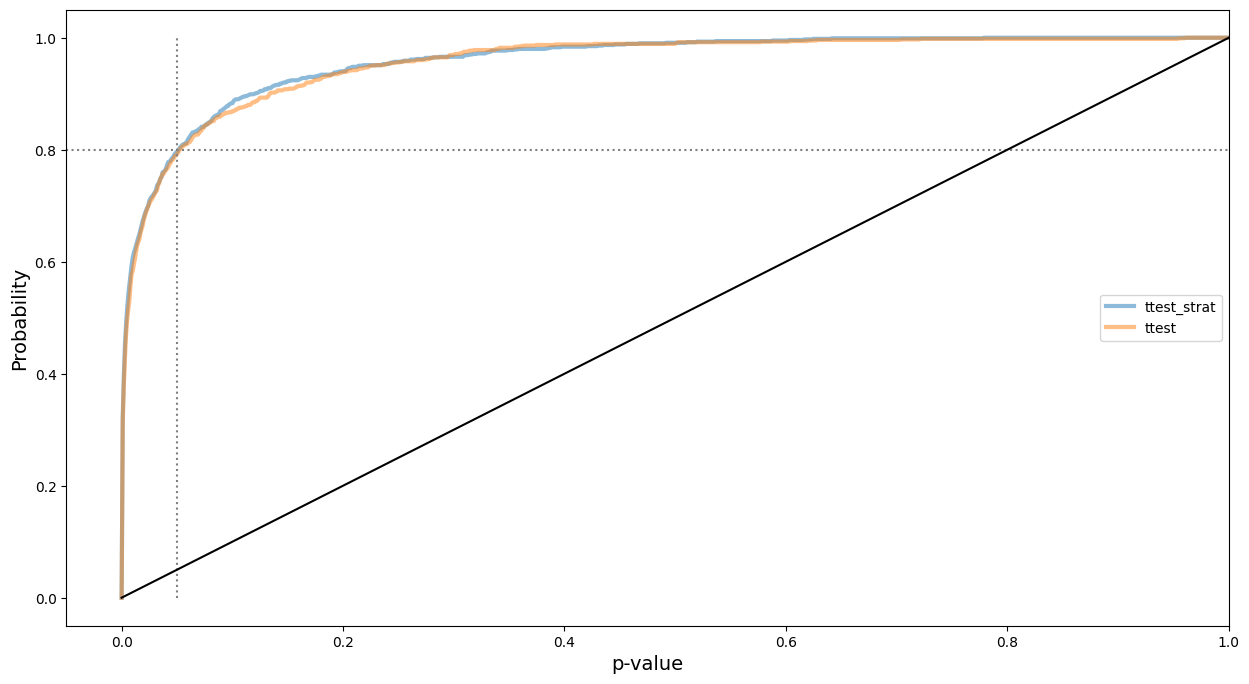

In [60]:
ttl_users = math.ceil(df_unregister_agg_wo_outlier['device_id'].nunique()/num_of_bucket)
weights = df_unregister_agg['device_model'].value_counts(normalize=True).to_dict()
effect = 2.4262
pvalues_ttest = []
pvalues_strat_ttest = []
mean = []
mean_strat = []
var = []
var_strat = []
for i in tqdm(range(1000)):
    
        df_control_wo_outlier = df_unregister_agg_wo_outlier.sample(n = ttl_users,replace=True)
        df_pilot_wo_outlier = df_unregister_agg_wo_outlier.sample(n = ttl_users,replace=True)
        df_pilot_wo_outlier['watchtime'] += effect
        means = df_pilot_wo_outlier['watchtime'].mean()
        vars = df_pilot_wo_outlier['watchtime'].var()
        pvalue = stats.ttest_ind(df_control_wo_outlier['watchtime'], df_pilot_wo_outlier['watchtime'])[1]
        
        df_control_wo_outlier_strat = df_unregister_agg_wo_outlier.sample(n = ttl_users,replace=True)
        df_pilot_wo_outlier_strat = df_unregister_agg_wo_outlier.sample(n = ttl_users,replace=True)
        df_pilot_wo_outlier_strat['watchtime'] += effect
        vars_strat = check_stratified_test(df_control_wo_outlier_strat, df_pilot_wo_outlier_strat,weights)[1]
        means_strat = check_stratified_test(df_control_wo_outlier_strat, df_pilot_wo_outlier_strat,weights)[2]
        pvalue_strat = check_stratified_test(df_control_wo_outlier_strat, df_pilot_wo_outlier_strat,weights)[0]
        
        pvalues_ttest.append(pvalue)
        pvalues_strat_ttest.append(pvalue_strat)                                
        mean.append(means)
        mean_strat.append(means_strat)                                  
        var.append(vars)
        var_strat.append(vars_strat)
        
list_pvalues = [pvalues_ttest,pvalues_strat_ttest]
list_titles = ['ttest','ttest_strat']
plt.figure(figsize=(15,8))
print("Среднее значение дисперсии без постстратификации:",np.mean(var))
print("Среднее значение дисперсии с постстратификацией:",np.mean(var_strat))

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
x_values = [0.05/(num_of_bucket - 1)]
plt.vlines(x_values, ymin=0, ymax=1, linestyles='dotted', colors='gray')
plt.axhline(y=0.8, color='gray', linestyle='dotted')
plt.xlim([-0.05, 1])
plt.xlabel('p-value', size=14)
plt.ylabel('Probability', size=14)
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()        

In [246]:
final_table_register = []

row1 = [watchtime_control, watchtime_test_1, watchtime_ttest_control_to_test1]
row2 = [broadcast_control, broadcast_test_1, broadcast_ttest_control_to_test1]

# row3 = [watchtime_control_1_start, watchtime_test_1_start, watchtime_ttest_control_to_test1_start]
# row4 = [watchtime_control_1_stairs, watchtime_test_1_stairs, watchtime_ttest_control_to_test1_stairs]
# row5 = [watchtime_control_1_actual, watchtime_test_1_actual, watchtime_ttest_control_to_test1_actual]

#row6 = [retention_1_day_control, retention_1_day_test_1, retention_1_day_ttest_control_to_test1] 
#row7 = [retention_3_day_control, retention_3_day_test_1, retention_3_day_ttest_control_to_test1]

# row8 = [register_control_, register_test_1, register_test_2, register_test_3, register_ttest_control_to_test1, register_ttest_control_to_test2, register_ttest_control_to_test3]
# row9 = [watchtime_start_select_control_1, watchtime_start_test_1, watchtime_start_test_2, watchtime_start_test_3, watchtime_start_ttest_control_to_test1, watchtime_start_ttest_control_to_test2, watchtime_start_ttest_control_to_test3]


final_table_register.append(row1)
final_table_register.append(row2)
# final_table_register.append(row3)
# final_table_register.append(row4)
# final_table_register.append(row5)
#final_table_register.append(row6)
#final_table_register.append(row7)
# final_table_register.append(row8)
# final_table_register.append(row9)





final_table_register = pd.DataFrame(final_table_register, index=['Watchtime за 7 дней, сек','Эфир за 7 дней'], columns=['контроль', 'тест 1', 'тест 1 к контролю'])

final_table_register['тест 1 к контролю']=np.where(final_table_register['тест 1 к контролю'].isna(), 0, np.where(final_table_register['тест 1 к контролю']<0.05/num_of_bucket, round((final_table_register['тест 1'] / final_table_register['контроль'] - 1) * 100,2), 'Нет различия'))
# final_table_register['тест 2 к контролю']=np.where(final_table_register['тест 2 к контролю'].isna(), 0, np.where(final_table_register['тест 2 к контролю']<0.05/num_of_bucket, round((final_table_register['тест 2'] / final_table_register['контроль'] - 1) * 100,2), 'Нет различия'))
# final_table_register['тест 3 к контролю']=np.where(final_table_register['тест 3 к контролю'].isna(), 0, np.where(final_table_register['тест 3 к контролю']<0.05/num_of_bucket, round((final_table_register['тест 3'] / final_table_register['контроль'] - 1) * 100,2), 'Нет различия'))
final_table_register

,контроль,тест 1,тест 1 к контролю
"Watchtime за 7 дней, сек",44.781162,46.920731,4.78
Эфир за 7 дней,9.632413,10.138022,Нет различия


In [247]:
final_table_register['тест 1 к контролю']= np.where(final_table_register['тест 1 к контролю']=='Нет различия',final_table_register['тест 1 к контролю'], np.where(final_table_register['тест 1 к контролю'].str.contains('-'),final_table_register['тест 1 к контролю'] + '%','+' + final_table_register['тест 1 к контролю'] + '%'))
# final_table_register['тест 2 к контролю']= np.where(final_table_register['тест 2 к контролю']=='Нет различия',final_table_register['тест 2 к контролю'], np.where(final_table_register['тест 2 к контролю'].str.contains('-'),final_table_register['тест 2 к контролю'] + '%','+' + final_table_register['тест 2 к контролю'] + '%'))
# final_table_register['тест 3 к контролю']= np.where(final_table_register['тест 3 к контролю']=='Нет различия',final_table_register['тест 3 к контролю'], np.where(final_table_register['тест 3 к контролю'].str.contains('-'),final_table_register['тест 3 к контролю'] + '%','+' + final_table_register['тест 3 к контролю'] + '%'))


## Фукнция для закраски ячеек

In [248]:
def color_cell(val):
    if val == 'Нет различия':
        return ''
    elif '+' in val:
        return 'background-color: lightgreen'
    else:
        return 'background-color:  #FFCCCB'

In [249]:
final_table_register[['контроль', 'тест 1','тест 1 к контролю']].style.applymap(color_cell, subset=['тест 1 к контролю'])

,контроль,тест 1,тест 1 к контролю
"Watchtime за 7 дней, сек",44.781162,46.920731,+4.78%
Эфир за 7 дней,9.632413,10.138022,Нет различия


# Зареги

## Вводные параметры

In [252]:
control_group = 'lenta__rltpw_control_A'
test_group_1 = 'lenta__rltpw_test_B'

num_of_bucket = 2  # Число групп

begin_date = datetime.strptime('2024-04-18', '%Y-%m-%d')
end_date = datetime.strptime('2024-04-25', '%Y-%m-%d')
cuped_date = begin_date - timedelta(days = 7) 

# Даты для retention 
day_retention_1_day = datetime.strptime('2024-04-24', '%Y-%m-%d') # крайний день интервала указывается 
day_retention_3_day = datetime.strptime('2024-04-21', '%Y-%m-%d') # минус 3 дня от крайнего дня 

In [253]:
df_register = df_merge[(df_merge['date_msk'] >= begin_date) & (df_merge['date_msk'] <= end_date) & (df_merge['empty_user'] == 0) & (df_merge['bot_flag'] == 0) & (~df_merge['score_str'].isin(['mid', 'high'])) & (df_merge['app_version_name'] != '1.49.0') & (df_merge['profile_type'] == 'Зарег')]
df_register_agg = df_register.groupby(['date_msk','experiment_group']).agg({'watchtime':'mean','broadcast':'mean'}).reset_index()
df_register_agg

,date_msk,experiment_group,watchtime,broadcast
0,2024-04-18,lenta__rltpw_control_A,138.873208,23.264613
1,2024-04-18,lenta__rltpw_test_B,131.145523,23.740373
2,2024-04-19,lenta__rltpw_control_A,150.986256,24.587753
3,2024-04-19,lenta__rltpw_test_B,138.489451,26.382979
4,2024-04-20,lenta__rltpw_control_A,165.608678,26.689134
5,2024-04-20,lenta__rltpw_test_B,166.588735,28.903361
6,2024-04-21,lenta__rltpw_control_A,154.735852,25.645885
7,2024-04-21,lenta__rltpw_test_B,137.368544,25.771843
8,2024-04-22,lenta__rltpw_control_A,146.869351,23.822254
9,2024-04-22,lenta__rltpw_test_B,144.056262,26.120290


In [254]:
t1 = df_register.groupby('device_id')['watchtime'].sum().reset_index()
t1['watchtime'].var()

567656.4160843394

In [255]:
df_register.groupby('date_msk')['device_id'].nunique()

date_msk
2024-04-18    5051
2024-04-19    4669
2024-04-20    4828
2024-04-21    4821
2024-04-22    4146
2024-04-23    4333
2024-04-25    5575
Name: device_id, dtype: int64

In [256]:
df_register_first_date = df_register[(df_register['first_date_in_app']!='2000-01-01') & (df_register['first_date_in_app']<day_retention_1_day) & (df_register['first_date_in_app']>=begin_date)]
df_register_first_date['first_date_in_app'].unique()

df_register_first_date_agg = df_register_first_date.groupby(['first_date_in_app','experiment_group']).agg({'d_0':'sum','d_1':'sum'}).reset_index()
df_register_first_date_agg['conv'] = df_register_first_date_agg['d_1'] / df_register_first_date_agg['d_0']
df_register_first_date_agg

,first_date_in_app,experiment_group,d_0,d_1,conv
0,2024-04-18,lenta__rltpw_control_A,662.0,292.0,0.441088
1,2024-04-18,lenta__rltpw_test_B,585.0,231.0,0.394872
2,2024-04-19,lenta__rltpw_control_A,651.0,242.0,0.371736
3,2024-04-19,lenta__rltpw_test_B,701.0,257.0,0.366619
4,2024-04-20,lenta__rltpw_control_A,853.0,328.0,0.384525
5,2024-04-20,lenta__rltpw_test_B,831.0,338.0,0.406739
6,2024-04-21,lenta__rltpw_control_A,720.0,251.0,0.348611
7,2024-04-21,lenta__rltpw_test_B,759.0,292.0,0.384717
8,2024-04-22,lenta__rltpw_control_A,552.0,167.0,0.302536
9,2024-04-22,lenta__rltpw_test_B,536.0,191.0,0.356343


In [257]:
df_register_third_date = df_register[(df_register['first_date_in_app']!='2000-01-01') & (df_register['first_date_in_app']<=day_retention_3_day) &  (df_register['first_date_in_app']>=begin_date)]
df_register_third_date['first_date_in_app'].unique()

df_register_third_date_agg = df_register_third_date.groupby(['first_date_in_app','experiment_group']).agg({'d_0':'sum','d_3':'sum'}).reset_index()
df_register_third_date_agg['conv'] = df_register_third_date_agg['d_3'] / df_register_third_date_agg['d_0']
df_register_third_date_agg

,first_date_in_app,experiment_group,d_0,d_3,conv
0,2024-04-18,lenta__rltpw_control_A,662.0,144.0,0.217523
1,2024-04-18,lenta__rltpw_test_B,585.0,97.0,0.165812
2,2024-04-19,lenta__rltpw_control_A,651.0,88.0,0.135177
3,2024-04-19,lenta__rltpw_test_B,701.0,109.0,0.155492
4,2024-04-20,lenta__rltpw_control_A,853.0,134.0,0.157093
5,2024-04-20,lenta__rltpw_test_B,831.0,143.0,0.172082
6,2024-04-21,lenta__rltpw_control_A,720.0,99.0,0.137500
7,2024-04-21,lenta__rltpw_test_B,759.0,142.0,0.187088


## Метрики в динамике по группам экспериментам (Все пользователи)

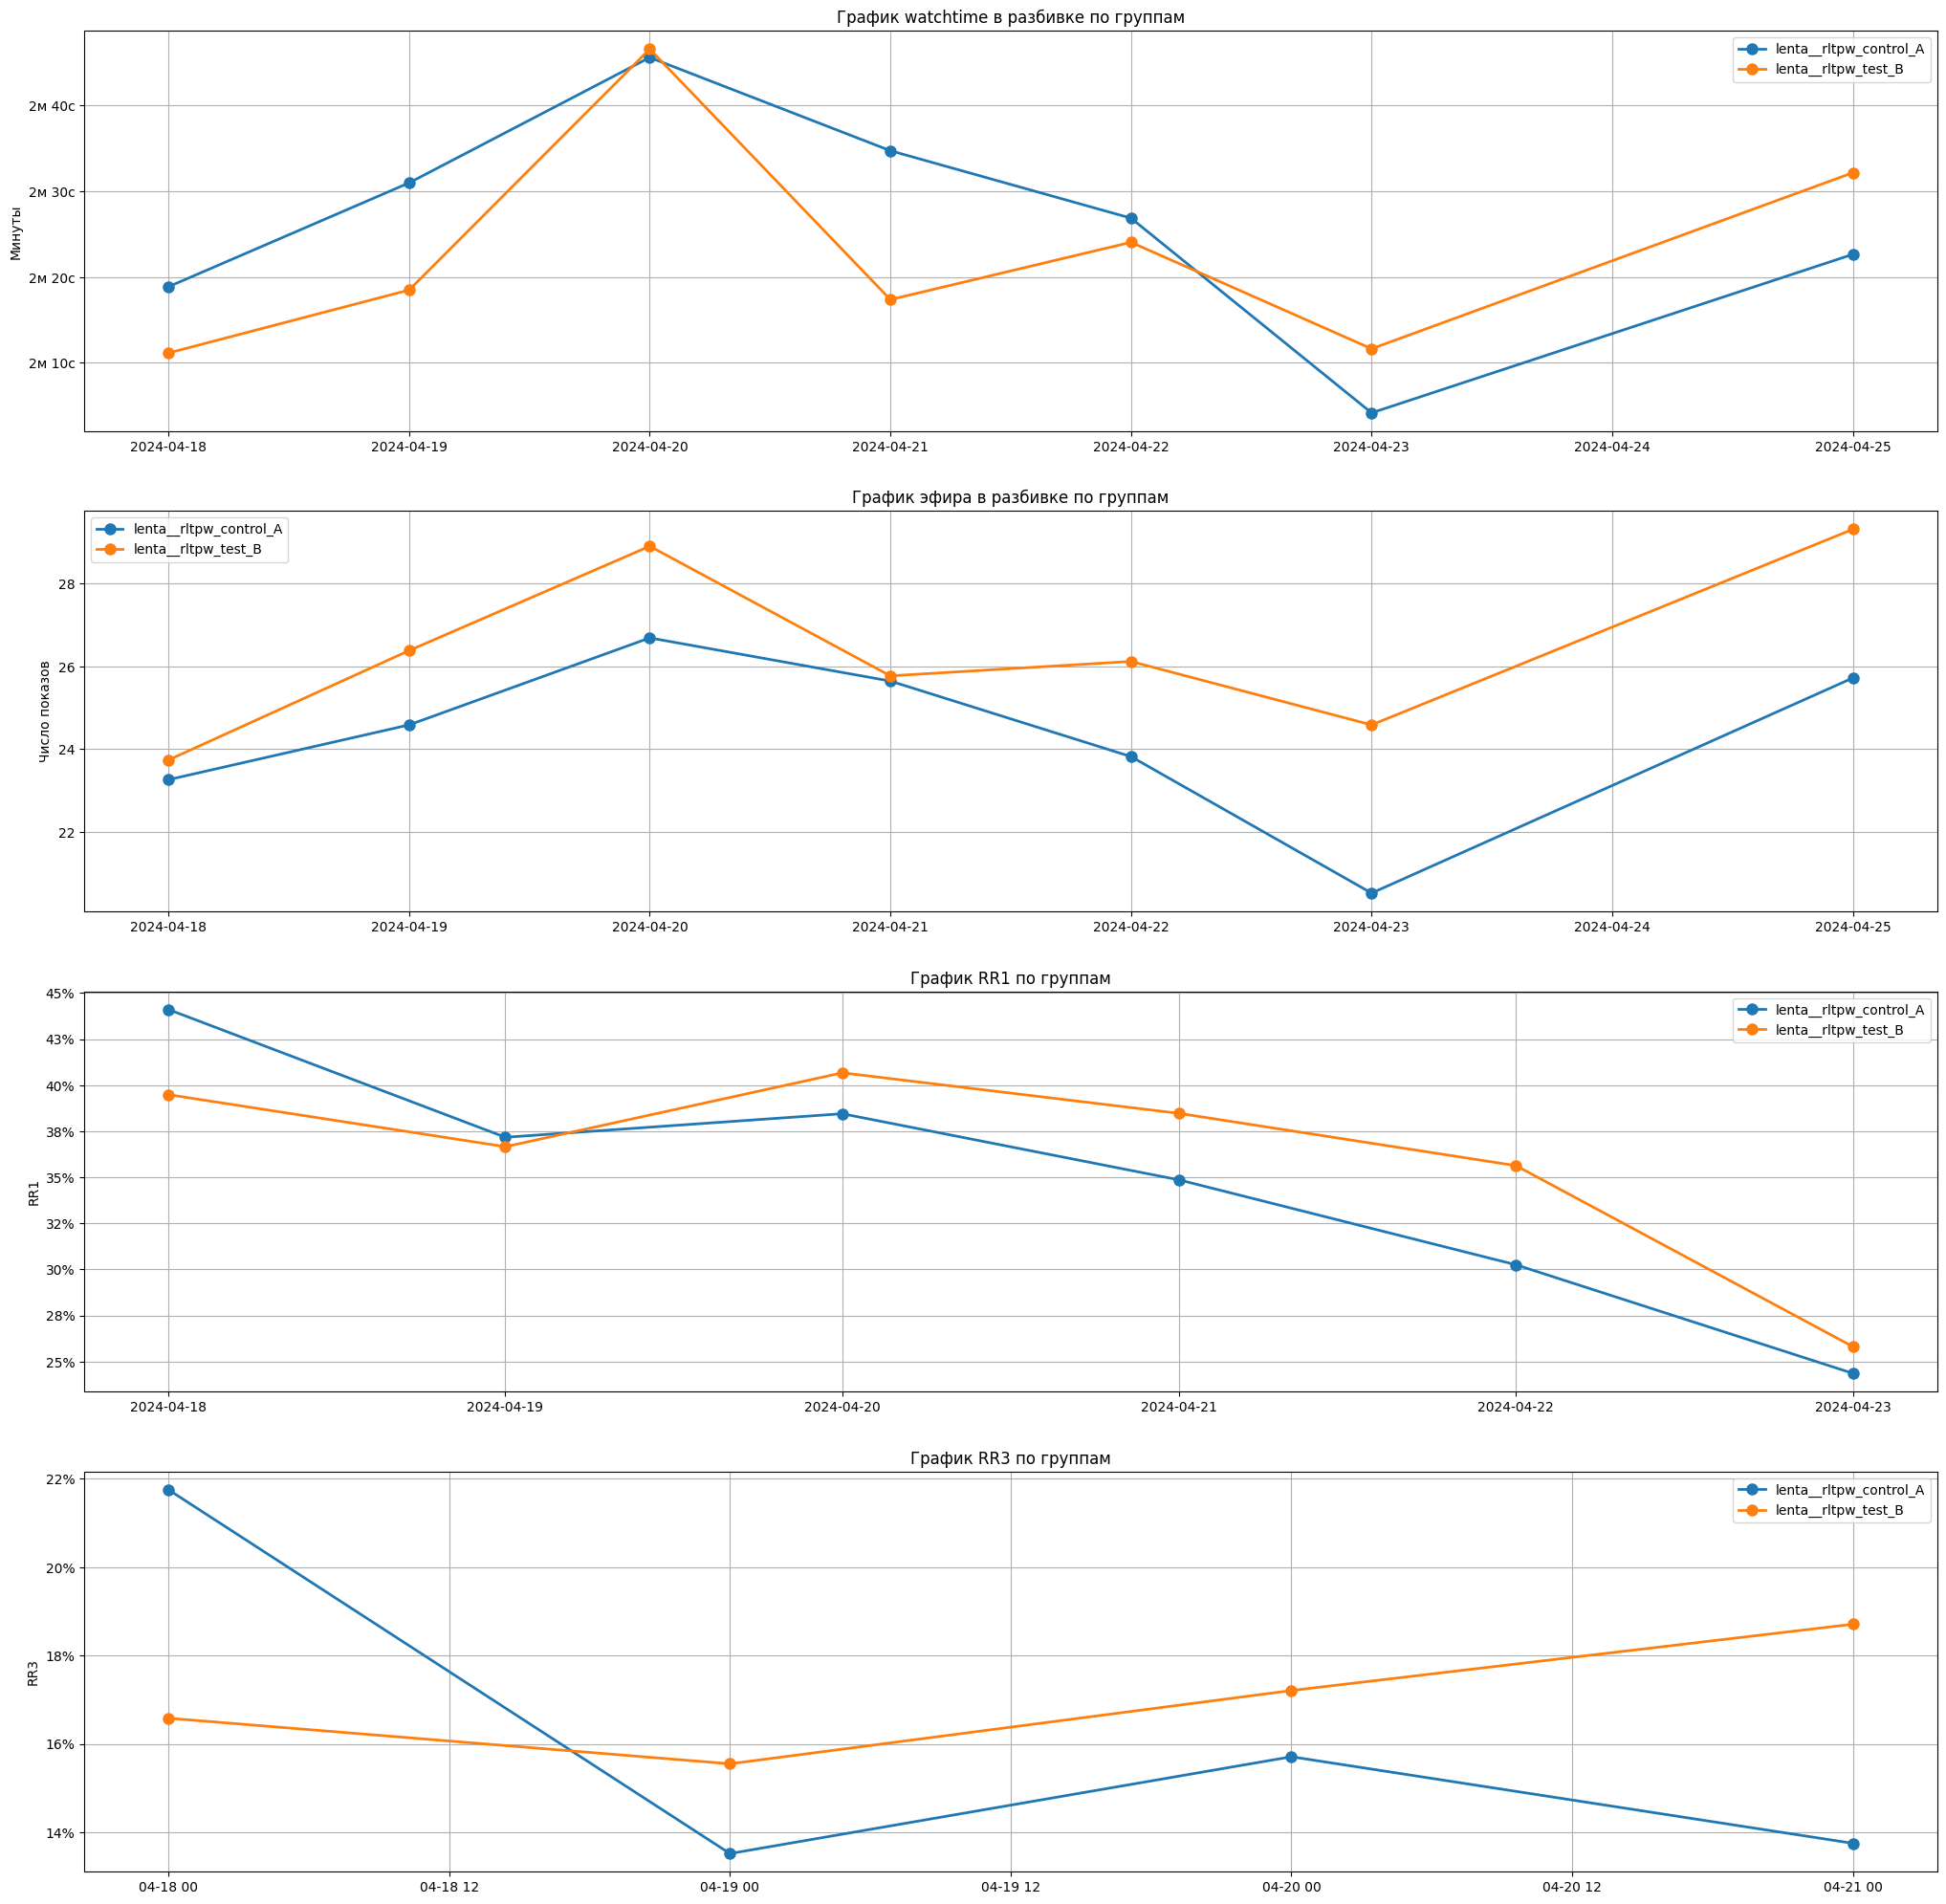

In [258]:
fix,axes = plt.subplots(4,1,figsize=(25,25))

def format_func(value, tick_number):
    minutes = int(value) // 60
    seconds = int(value) % 60
    return f"{minutes}м {seconds}с"

# цикл по всем значениям experiment group
for i in df_register_agg['experiment_group'].unique():
    t = df_register_agg[df_register_agg['experiment_group']==i]

    axes[0].plot(t['date_msk'], t['watchtime'], label=i,linewidth=2, marker='o', markersize=8)
    axes[1].plot(t['date_msk'], t['broadcast'], label=i,linewidth=2, marker='o', markersize=8)
    
for i in df_register_first_date_agg['experiment_group'].unique():
    t1 = df_register_first_date_agg[df_register_first_date_agg['experiment_group']==i]
    axes[2].plot(t1['first_date_in_app'], t1['conv'], label=i,linewidth=2, marker='o', markersize=8)
    

for i in df_register_third_date_agg['experiment_group'].unique():
    t3 = df_register_third_date_agg[df_register_third_date_agg['experiment_group']==i]
    axes[3].plot(t3['first_date_in_app'], t3['conv'], label=i,linewidth=2, marker='o', markersize=8)
    


for i in range(4):    
     axes[i].grid(True)

# Увеличиваем расстояние между графиками
plt.subplots_adjust(hspace=0.2)    


axes[0].set_title('График watchtime в разбивке по группам')
axes[0].legend()
axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
axes[0].set_ylabel('Минуты')


axes[1].set_title('График эфира в разбивке по группам')
axes[1].legend()
axes[1].set_ylabel('Число показов')

axes[2].set_title('График RR1 по группам')
axes[2].legend()
axes[2].set_ylabel('RR1')
axes[2].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

axes[3].set_title('График RR3 по группам')
axes[3].legend()
axes[3].set_ylabel('RR3')
axes[3].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

plt.show()
axes[0].figure.savefig(f"Графики по всем пользователям '{end_date}'.jpg")

## Метрики в динамике по группам экспериментам (Зареги)

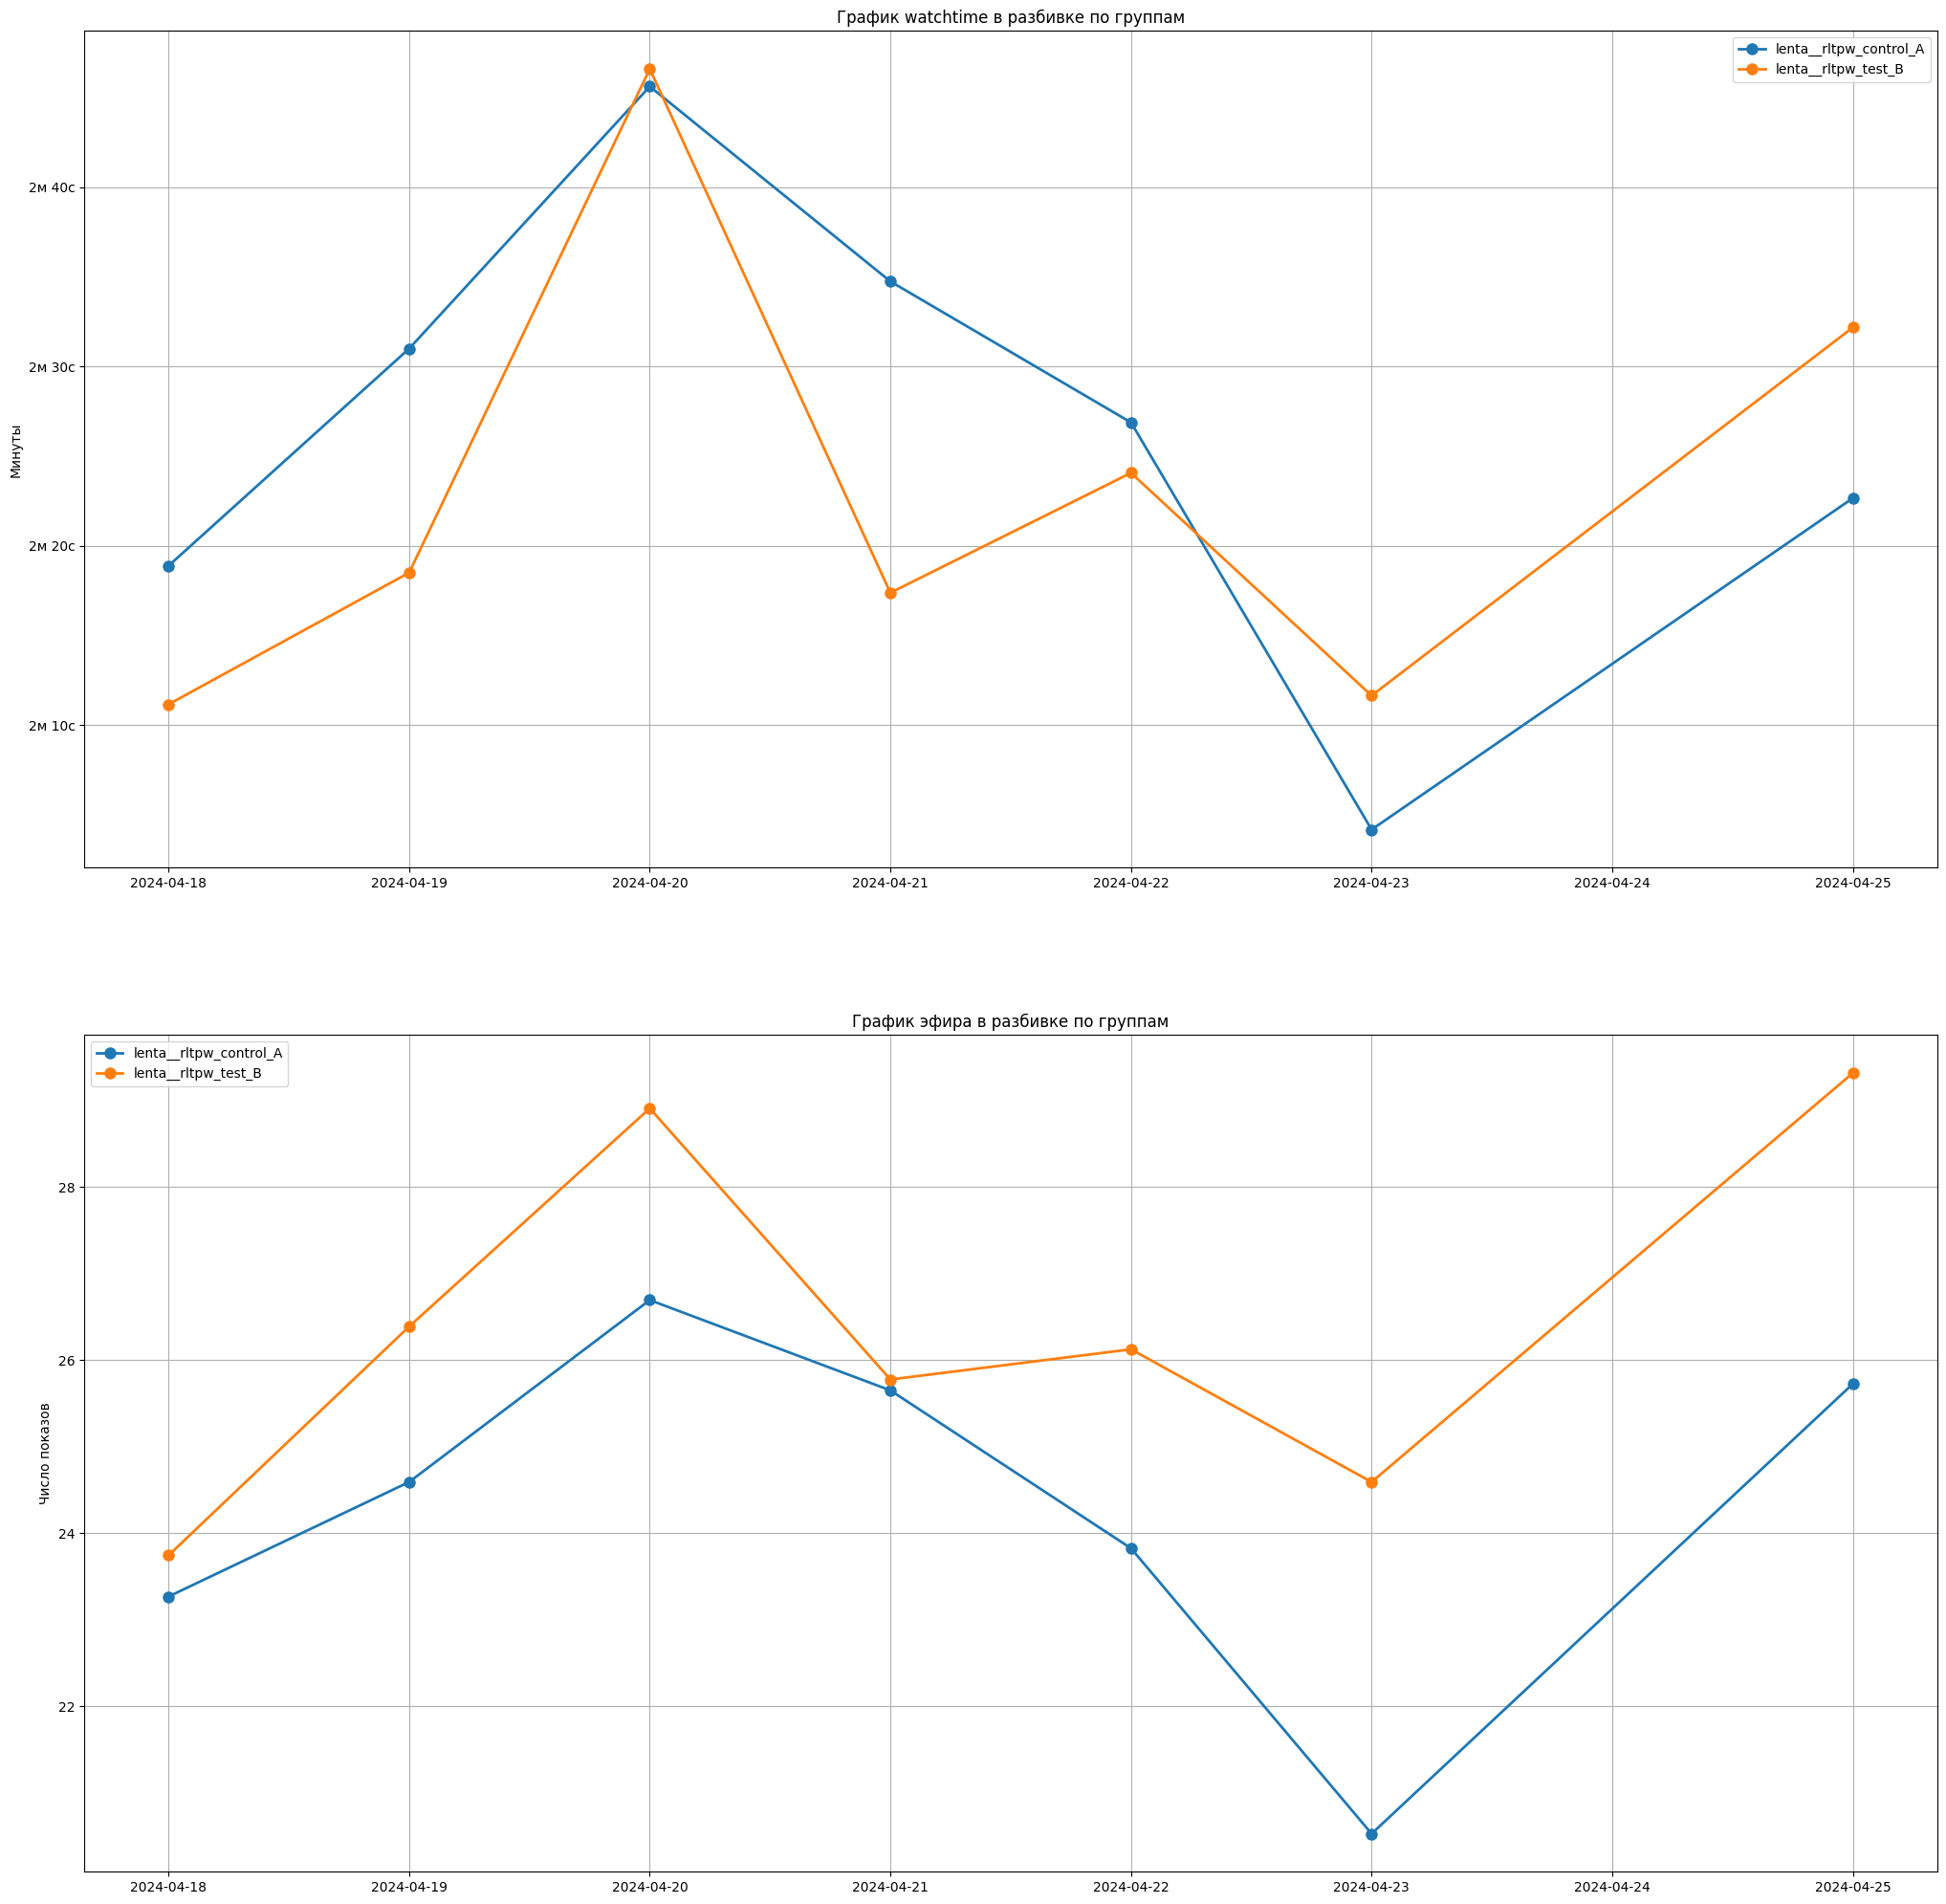

In [259]:
fix,axes = plt.subplots(2,1,figsize=(25,25))

def format_func(value, tick_number):
    minutes = int(value) // 60
    seconds = int(value) % 60
    return f"{minutes}м {seconds}с"

# цикл по всем значениям experiment group
for i in df_register_agg['experiment_group'].unique():
    t = df_register_agg[df_register_agg['experiment_group']==i]

    axes[0].plot(t['date_msk'], t['watchtime'], label=i,linewidth=2, marker='o', markersize=8)
    axes[1].plot(t['date_msk'], t['broadcast'], label=i,linewidth=2, marker='o', markersize=8)
    
# for i in df_unregister_first_date_agg['experiment_group'].unique():
#     t1 = df_unregister_first_date_agg[df_unregister_first_date_agg['experiment_group']==i]
#     axes[2].plot(t1['first_date_in_app'], t1['conv'], label=i,linewidth=2, marker='o', markersize=8)
    

# for i in df_unregister_third_date_agg['experiment_group'].unique():
#     t3 = df_unregister_third_date_agg[df_unregister_third_date_agg['experiment_group']==i]
#     axes[3].plot(t3['first_date_in_app'], t3['conv'], label=i,linewidth=2, marker='o', markersize=8)
    

for i in range(2):    
     axes[i].grid(True)

# Увеличиваем расстояние между графиками
plt.subplots_adjust(hspace=0.2)    


axes[0].set_title('График watchtime в разбивке по группам')
axes[0].legend()
axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
axes[0].set_ylabel('Минуты')


axes[1].set_title('График эфира в разбивке по группам')
axes[1].legend()
axes[1].set_ylabel('Число показов')

# axes[2].set_title('График RR1 по группам')
# axes[2].legend()
# axes[2].set_ylabel('RR1')
# axes[2].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

# axes[3].set_title('График RR3 по группам')
# axes[3].legend()
# axes[3].set_ylabel('RR3')
# axes[3].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

plt.show()
axes[0].figure.savefig(f"Графики по незарегам '{end_date}'.jpg")

## Тест на независимость

In [260]:
# Функция для хи-квадра по определению независимости между выборками
def chi_independence(df, control, test_1, segment_name, part=None):
        '''H0: distributions are independent, H1: distributions are dependent '''
        for segment in segment_name:
                control1 = df[df['experiment_group'] == control][segment].value_counts()
                test1 = df[df['experiment_group'] == test_1][segment].value_counts()
                # test2 = df[df['experiment_group'] == test_2][segment].value_counts()
                # test3 = df[df['experiment_group'] == test_3][segment].value_counts()
                
                #concat = pd.concat([control1,test1,test2,test3], axis=1)
                #concat.columns = ['control_1','test_1','test_2','test_3']
                concat = pd.concat([control1,test1], axis=1)
                concat.columns = ['control','test_1']
                if part:
                    print(concat.iloc[:part])
                    stat, p_value, dof, expected = stats.chi2_contingency(concat.iloc[:part])
                else:
                    stat, p_value, dof, expected = stats.chi2_contingency(concat)

                if p_value <= 0.01:
                        print (f" {segment}- p-value: {p_value:.4f}, statistic: {stat:.4f}, dof: {dof}, dependent (reject H0)\n")
                else:
                        print (f" {segment} - p-value: {p_value:.4f}, statistic: {stat:.4f}, dof: {dof}, independent (fail to reject H0)\n")


In [261]:
chi_independence(df_register,
                  control_group,
                  test_group_1,
                  #test_group_2,
                  #test_group_3,
                 ["os_name","country_type","device_manufacturer","device_model","app_version_name","os_version"],
                 15
                )

         control  test_1
os_name                 
1          14060   13836
0           2688    2839
 os_name - p-value: 0.0170, statistic: 5.6942, dof: 1, independent (fail to reject H0)

              control  test_1
country_type                 
Россия          16056   16050
СНГ               494     443
Остальные          82      81
 country_type - p-value: 0.2616, statistic: 2.6818, dof: 2, independent (fail to reject H0)

                      control  test_1
device_manufacturer                  
Redmi                  3220.0  3123.0
Apple                  2602.0  2763.0
Samsung                2269.0  2180.0
Tecno                  1472.0  1546.0
Huawei                 1433.0  1349.0
Realme                 1389.0  1443.0
Infinix                1115.0   960.0
Xiaomi                  747.0   778.0
POCO                    516.0   526.0
Honor                   480.0   516.0
Vivo                    345.0   333.0
Oppo                    253.0   287.0
TECNO MOBILE LIMITED    152.0   151.0

## Тест на SRM (тест на однородность)

In [262]:
def chi_homogeneity(df, control, test_1, segment_name,number_of_groups, part=None):
    '''H0: distributions are homogeneous, H1: distributions are not homogeneous '''
    for segment in segment_name:
            control1 = df[df['experiment_group'] == control][segment].value_counts()
            test1 = df[df['experiment_group'] == test_1][segment].value_counts()
            # test2 = df[df['experiment_group'] == test_2][segment].value_counts()
            # test3 = df[df['experiment_group'] == test_3][segment].value_counts()
            concat = pd.concat([control1,test1], axis=1)
            concat.columns = ['control_1','test_1']
            concat['expected']=concat.sum(axis=1).apply(lambda x: math.ceil(x / number_of_groups))
            print(concat.iloc[:part])
            for i in concat.columns[:-1]:
                    # рассчитываем статистику
                    k = len(concat[i].iloc[:part])                                                                                             # число степеней свободы 
                    statistic = (((concat[i].iloc[:part] - concat['expected'].iloc[:part])**2)/concat['expected'].iloc[:part]).sum()           # КСП
                    # рассчитываем p-value 
                    p_value = 1 - stats.chi2.cdf(statistic, k - 1)                                                                             # вероятность получить значение выше или равное статистике
                    if p_value <= 0.01:
                            print (f" {segment}- p-value: {p_value:.4f}, statistic: {statistic:.4f}, dof: {k-1}, homogenes (reject H0)\n")
                    else:
                            print (f" {segment} - p-value: {p_value:.4f}, statistic: {statistic:.4f}, dof: {k-1}, not homogenes (fail to reject H0)\n")


In [263]:
chi_homogeneity(df_register,
                  control_group,
                  test_group_1,
                  # test_group_2,
                  # test_group_3,
                  ["os_name","country_type","device_manufacturer","device_model","app_version_name","os_version"],
                 num_of_bucket, # Количество групп в тесте 
                 15)

         control_1  test_1  expected
os_name                             
1            14060   13836     13948
0             2688    2839      2764
 os_name - p-value: 0.0838, statistic: 2.9891, dof: 1, not homogenes (fail to reject H0)

 os_name - p-value: 0.0867, statistic: 2.9344, dof: 1, not homogenes (fail to reject H0)

              control_1  test_1  expected
country_type                             
Россия            16056   16050     16053
СНГ                 494     443       469
Остальные            82      81        82
 country_type - p-value: 0.5135, statistic: 1.3332, dof: 2, not homogenes (fail to reject H0)

 country_type - p-value: 0.4833, statistic: 1.4541, dof: 2, not homogenes (fail to reject H0)

                      control_1  test_1  expected
device_manufacturer                              
Redmi                    3220.0  3123.0      3172
Apple                    2602.0  2763.0      2683
Samsung                  2269.0  2180.0      2225
Tecno                 

## Распределения 

In [264]:
def plot_segments_distribution(df, segment_columns, test_factor):
    for i in segment_columns:
        aggregated_data = df.groupby(by = [test_factor,i])['device_id'].count().reset_index()
        sns.catplot(x = i, 
                    y = 'device_id', 
                    hue = test_factor, # сообщаем, что хотим, чтобы разные группы имели разный цвет
                    data = aggregated_data.sort_values(by='device_id', ascending=False).iloc[:40], 
                    kind = "bar", 
                    height = 4, # задаем размер графика 
                    aspect = 1.5) # задаем ширину столбца
        plt.xticks(rotation=100)

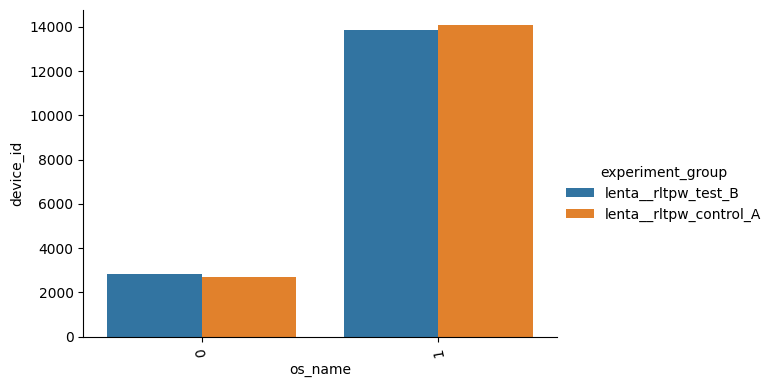

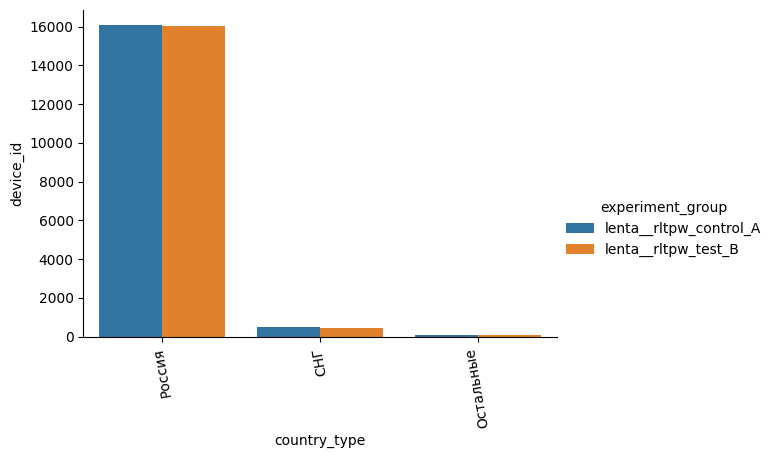

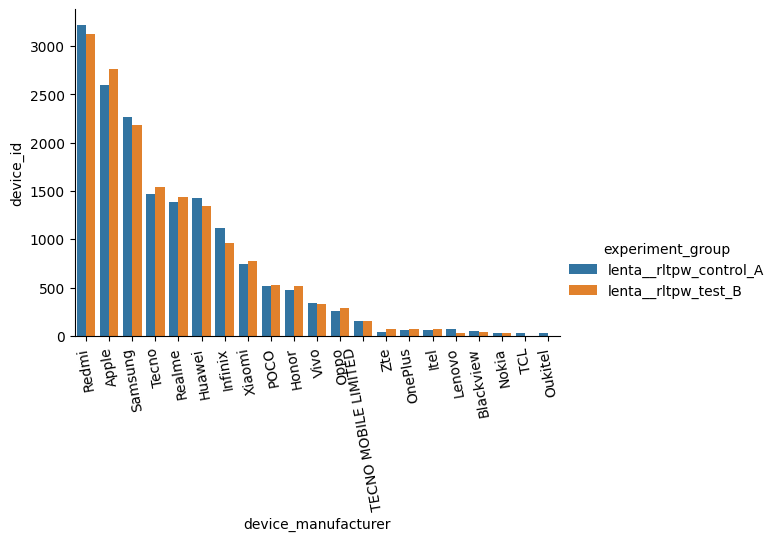

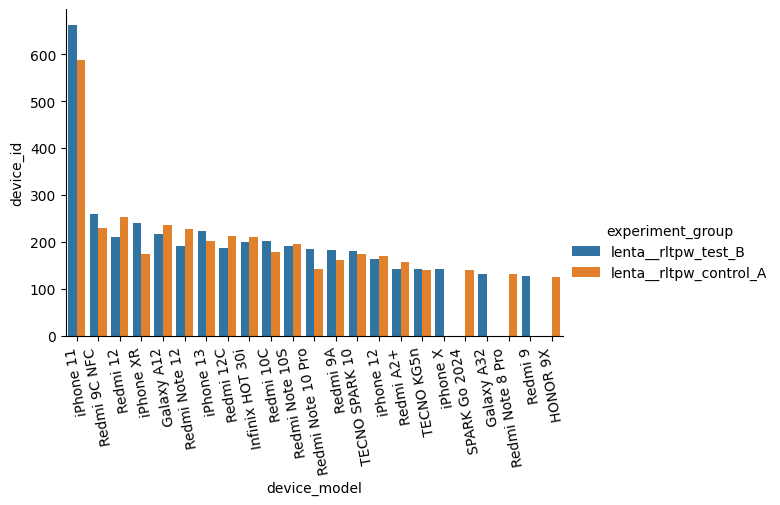

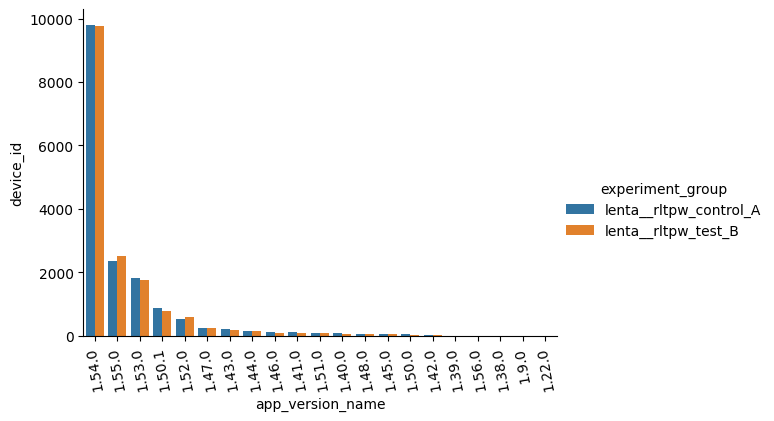

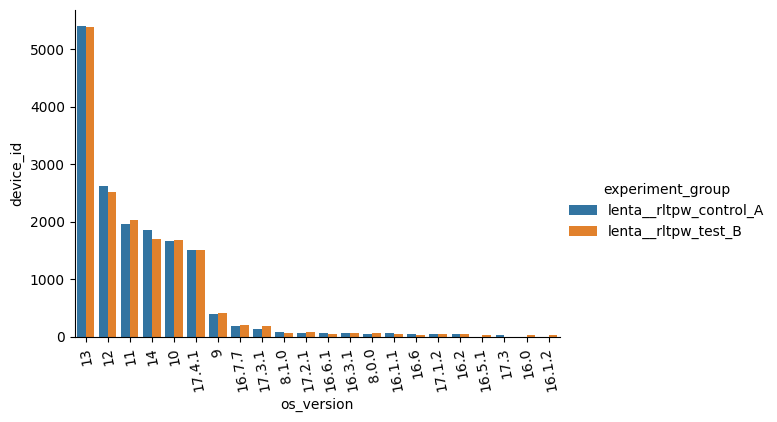

In [265]:
plot_segments_distribution(df_register, #датафрейм
                          ["os_name","country_type","device_manufacturer","device_model","app_version_name","os_version"],
                           "experiment_group",) #тест-фактор

## Добавим предэксперементальную группу

In [266]:
df_register_agg = df_register.groupby(['device_id','os_name','os_version','app_version_name','device_manufacturer','device_model','country_type','experiment_group','first_date_in_app','d_0','d_1','d_3']).agg({'watchtime':'sum','broadcast':'sum'}).reset_index()
df_register_agg

,device_id,os_name,os_version,app_version_name,device_manufacturer,device_model,country_type,experiment_group,first_date_in_app,d_0,d_1,d_3,watchtime,broadcast
0,0003cf31-3e30-3a4f-8bf0-e2bbd1d714d5,1,13,1.54.0,Realme,realme 10,Россия,lenta__rltpw_test_B,2000-01-01,0.0,0.0,0.0,82.464,14
1,000744db-d12d-4885-a3db-918e25e052c5,0,17.4.1,1.55.0,Apple,iPhone 14 Pro Max,Россия,lenta__rltpw_test_B,2024-04-20,1.0,0.0,0.0,3.082,5
2,000ce9f7-bcac-3d5e-a2c9-4d24c3ea0903,1,13,1.54.0,Samsung,Galaxy A22 5G,Россия,lenta__rltpw_control_A,2024-04-23,1.0,0.0,0.0,12.196,3
3,000e5e4d-14a2-3363-85aa-335a3d036821,1,12,1.54.0,Tecno,TECNO POVA 3,Россия,lenta__rltpw_control_A,2000-01-01,0.0,0.0,0.0,0.000,3
4,000eec2b-efc6-348c-95c2-4883bd16c1b9,1,13,1.53.0,Tecno,CAMON 19 Pro,Россия,lenta__rltpw_control_A,2000-01-01,0.0,0.0,0.0,13.107,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23297,fffa2d49-05fd-37bb-bad5-df6a3b11322b,1,13,1.54.0,Honor,HONOR 50,Россия,lenta__rltpw_control_A,2000-01-01,0.0,0.0,0.0,2.864,2
23298,fffa6b90-14fc-34e1-b247-8b2b6a9e3238,1,11,1.54.0,Xiaomi,Redmi Note 8,СНГ,lenta__rltpw_control_A,2024-04-21,1.0,1.0,0.0,56.927,18
23299,fffa6cba-3cd4-3cca-889b-11f472409c65,1,13,1.54.0,Tecno,TECNO SPARK 10 Pro,Россия,lenta__rltpw_control_A,2024-04-21,1.0,0.0,0.0,6.933,6
23300,fffa7433-b0fc-36a1-b5de-8ddc20eb7eb0,1,12,1.53.0,Oppo,A17k,Россия,lenta__rltpw_test_B,2024-04-15,1.0,0.0,0.0,1760.285,259


In [267]:
df_register_agg['watchtime'].var()

572260.7576406796

In [268]:
print(df_register_agg['device_id'].count())
print(df_register_agg['device_id'].nunique())

23302
23302


In [269]:
df_register_pre_week = df_merge[(df_merge['date_msk'] >= cuped_date) & (df_merge['date_msk'] < begin_date) & (df_merge['empty_user'] == 0) & (df_merge['bot_flag'] == 0) & (~df_merge['score_str'].isin(['mid', 'high'])) & (df_merge['profile_type'] == 'Зарег') & (df_merge['app_version_name'] != '1.49.0')]
df_register_agg_pre_week = df_register_pre_week.groupby(['device_id','os_name','os_version','app_version_name','device_manufacturer','device_model','country_type','experiment_group','first_date_in_app','d_0','d_1','d_3']).agg({'watchtime':'sum','broadcast':'sum'}).reset_index()


df_register_pre_week['date_msk'].unique()

<DatetimeArray>
['2024-04-15 00:00:00', '2024-04-12 00:00:00', '2024-04-13 00:00:00',
 '2024-04-14 00:00:00', '2024-04-17 00:00:00', '2024-04-11 00:00:00',
 '2024-04-16 00:00:00']
Length: 7, dtype: datetime64[ns]

In [270]:
df_register_agg_merge = pd.merge(df_register_agg,df_register_agg_pre_week[['device_id','watchtime']],on='device_id',how='left')
df_register_agg_merge.fillna(0,inplace=True)
df_register_agg_merge.rename(columns = {'watchtime_x':'watchtime_experiment','watchtime_y':'watchtime_pre_experiment'},inplace=True)


df_register_agg_merge['new_type'] = np.where(df_register_agg_merge['first_date_in_app']=='2000-01-01','Удержанные','Новые')
df_register_agg_merge

,device_id,os_name,os_version,app_version_name,device_manufacturer,device_model,country_type,experiment_group,first_date_in_app,d_0,d_1,d_3,watchtime_experiment,broadcast,watchtime_pre_experiment,new_type
0,0003cf31-3e30-3a4f-8bf0-e2bbd1d714d5,1,13,1.54.0,Realme,realme 10,Россия,lenta__rltpw_test_B,2000-01-01,0.0,0.0,0.0,82.464,14,1147.406,Удержанные
1,000744db-d12d-4885-a3db-918e25e052c5,0,17.4.1,1.55.0,Apple,iPhone 14 Pro Max,Россия,lenta__rltpw_test_B,2024-04-20,1.0,0.0,0.0,3.082,5,0.000,Новые
2,000ce9f7-bcac-3d5e-a2c9-4d24c3ea0903,1,13,1.54.0,Samsung,Galaxy A22 5G,Россия,lenta__rltpw_control_A,2024-04-23,1.0,0.0,0.0,12.196,3,0.000,Новые
3,000e5e4d-14a2-3363-85aa-335a3d036821,1,12,1.54.0,Tecno,TECNO POVA 3,Россия,lenta__rltpw_control_A,2000-01-01,0.0,0.0,0.0,0.000,3,0.344,Удержанные
4,000eec2b-efc6-348c-95c2-4883bd16c1b9,1,13,1.53.0,Tecno,CAMON 19 Pro,Россия,lenta__rltpw_control_A,2000-01-01,0.0,0.0,0.0,13.107,2,0.000,Удержанные
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23297,fffa2d49-05fd-37bb-bad5-df6a3b11322b,1,13,1.54.0,Honor,HONOR 50,Россия,lenta__rltpw_control_A,2000-01-01,0.0,0.0,0.0,2.864,2,0.000,Удержанные
23298,fffa6b90-14fc-34e1-b247-8b2b6a9e3238,1,11,1.54.0,Xiaomi,Redmi Note 8,СНГ,lenta__rltpw_control_A,2024-04-21,1.0,1.0,0.0,56.927,18,0.000,Новые
23299,fffa6cba-3cd4-3cca-889b-11f472409c65,1,13,1.54.0,Tecno,TECNO SPARK 10 Pro,Россия,lenta__rltpw_control_A,2024-04-21,1.0,0.0,0.0,6.933,6,0.000,Новые
23300,fffa7433-b0fc-36a1-b5de-8ddc20eb7eb0,1,12,1.53.0,Oppo,A17k,Россия,lenta__rltpw_test_B,2024-04-15,1.0,0.0,0.0,1760.285,259,0.000,Новые


## Квантильный анализ

In [271]:
quantiles=[1,2,3,4,5,6,7,8,9,10,25,50,75,80,85,90,91,92,93,94,95,96,97,98,99]
columns = ['watchtime_experiment','broadcast']


# пустой df для хранения результатов
quantiles_data = pd.DataFrame(index=quantiles, columns=columns)

for i in columns:
    data = df_register_agg_merge[i].dropna()
    quantile_values = np.percentile(data, quantiles)
    quantiles_data[i] = quantile_values

quantiles_data

,watchtime_experiment,broadcast
1,0.00000,1.00
2,0.00000,1.00
3,0.00000,1.00
4,0.00000,1.00
5,0.00000,1.00
6,0.00000,1.00
7,0.00000,1.00
8,0.00000,1.00
9,0.00000,1.00
10,0.14510,1.00


In [272]:
# Убираем 95 квантиль 
df_register_agg_wo_outlier = df_register_agg_merge[(df_register_agg_merge['watchtime_experiment']<np.percentile(df_register_agg_merge['watchtime_experiment'],95))]

# df_svr_merge_agg_wo_outlier_start = df_svr_merge_agg_start[(df_svr_merge_agg_start['watchtime']<np.percentile(df_svr_merge_agg_start['watchtime'],95))]
# df_svr_merge_agg_wo_outlier_stairs = df_svr_merge_agg_stairs[(df_svr_merge_agg_stairs['watchtime']<np.percentile(df_svr_merge_agg_stairs['watchtime'],95))]
# df_svr_merge_agg_wo_outlier_actual = df_svr_merge_agg_actual[(df_svr_merge_agg_actual['watchtime']<np.percentile(df_svr_merge_agg_actual['watchtime'],95))]

In [273]:
df_register_agg_wo_outlier['watchtime_experiment'].var()

27329.083587916586

In [274]:
grouped_df = df_register_agg_wo_outlier.groupby('experiment_group').agg({'device_id':'count'})
total_count = grouped_df['device_id'].sum()
grouped_df.loc['Total'] = [total_count]
grouped_df

,device_id
experiment_group,
lenta__rltpw_control_A,11094
lenta__rltpw_test_B,11042
Total,22136


In [275]:
df_register_agg_merge.groupby('experiment_group')['watchtime_experiment'].mean()

experiment_group
lenta__rltpw_control_A    209.554032
lenta__rltpw_test_B       205.769215
Name: watchtime_experiment, dtype: float64

In [276]:
df_register_agg_wo_outlier.groupby('experiment_group')['watchtime_experiment'].mean()

experiment_group
lenta__rltpw_control_A    93.316029
lenta__rltpw_test_B       97.220019
Name: watchtime_experiment, dtype: float64

## Деление на группы эксперимента

In [277]:
control = df_register_agg_wo_outlier[df_register_agg_wo_outlier['experiment_group']==control_group]
test_1 = df_register_agg_wo_outlier[df_register_agg_wo_outlier['experiment_group']==test_group_1]

In [278]:
control[control['new_type']=='Удержанные']

,device_id,os_name,os_version,app_version_name,device_manufacturer,device_model,country_type,experiment_group,first_date_in_app,d_0,d_1,d_3,watchtime_experiment,broadcast,watchtime_pre_experiment,new_type
3,000e5e4d-14a2-3363-85aa-335a3d036821,1,12,1.54.0,Tecno,TECNO POVA 3,Россия,lenta__rltpw_control_A,2000-01-01,0.0,0.0,0.0,0.000,3,0.344,Удержанные
4,000eec2b-efc6-348c-95c2-4883bd16c1b9,1,13,1.53.0,Tecno,CAMON 19 Pro,Россия,lenta__rltpw_control_A,2000-01-01,0.0,0.0,0.0,13.107,2,0.000,Удержанные
5,000fa301-aef0-3212-8c7f-737b62e1c254,1,13,1.54.0,Xiaomi,Xiaomi 11 Lite 5G NE,Россия,lenta__rltpw_control_A,2000-01-01,0.0,0.0,0.0,98.631,44,0.000,Удержанные
11,001b051c-133b-3a53-8f10-f5a49bbe2f14,1,10,1.54.0,Huawei,HUAWEI P30 lite,Россия,lenta__rltpw_control_A,2000-01-01,0.0,0.0,0.0,2.081,2,0.000,Удержанные
12,00296f9f-6de2-327c-98af-4f42711857ef,1,12,1.54.0,Huawei,MAO-LX9N,Россия,lenta__rltpw_control_A,2000-01-01,0.0,0.0,0.0,477.049,80,165.486,Удержанные
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23290,fff0585b-e830-3008-a245-90e3f95afee8,1,13,1.54.0,Samsung,Galaxy A51,Россия,lenta__rltpw_control_A,2000-01-01,0.0,0.0,0.0,133.737,23,62.649,Удержанные
23291,fff221a6-bd5b-30fb-bfae-1ea4214004d7,1,13,1.46.0,Redmi,Redmi Note 10S,Россия,lenta__rltpw_control_A,2000-01-01,0.0,0.0,0.0,0.000,1,0.000,Удержанные
23294,fff7efc7-40c7-3762-8176-d57ae327c675,1,11,1.54.0,Oukitel,WP12_Pro,Россия,lenta__rltpw_control_A,2000-01-01,0.0,0.0,0.0,342.045,28,41.266,Удержанные
23297,fffa2d49-05fd-37bb-bad5-df6a3b11322b,1,13,1.54.0,Honor,HONOR 50,Россия,lenta__rltpw_control_A,2000-01-01,0.0,0.0,0.0,2.864,2,0.000,Удержанные


## Постстратификация + CUPED

In [279]:
def calculate_theta(y_control, y_pilot, x_control, x_pilot):
    """Вычисляем Theta по данным двух групп """
    y = np.hstack([y_control, y_pilot])
    x = np.hstack([x_control, x_pilot])
    covariance = np.cov(x, y)[0, 1]
    variance = x.var()
    theta = covariance / variance
    return theta 

In [280]:
control[control['new_type']=='Удержанные']['watchtime_pre_experiment']

3          0.344
4          0.000
5          0.000
11         0.000
12       165.486
          ...   
23290     62.649
23291      0.000
23294     41.266
23297      0.000
23301     90.420
Name: watchtime_pre_experiment, Length: 6850, dtype: float64

In [281]:
theta = calculate_theta (
                        control[control['new_type']=='Удержанные']['watchtime_experiment'], test_1[test_1['new_type']=='Удержанные']['watchtime_experiment'],
                        control[control['new_type']=='Удержанные']['watchtime_pre_experiment'], test_1[test_1['new_type']=='Удержанные']['watchtime_pre_experiment']
                        )



print(f'theta = {theta}')

theta = 0.0686388582131737


In [282]:
def calculate_strat_var(df, weights, covariate):
    """Вычисляет стратифицированную дисперсию."""
    strat_vars = df.groupby('device_model')[covariate].var()
    df_vars_weights = pd.merge(
        strat_vars,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_vars_weights['weight'] = df_vars_weights['weight'] / df_vars_weights['weight'].sum()
    var_strat = (df_vars_weights['weight'] * df_vars_weights[covariate]).sum()
    return var_strat

In [283]:
def calculate_stratified_mean(df, weights, covariate):
    """Вычисляет стратифицированное среднее.

    df - датафрейм с целевой метрикой и данными для стратификации
    weights - словарь - {название страты: вес страты}

    return: float, mean_strat
    """
    strat_mean = df.groupby('device_model')[covariate].mean()
    df_means_weights = pd.merge(
        strat_mean,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_means_weights['weight'] = df_means_weights['weight'] / df_means_weights['weight'].sum()
    mean_strat = (df_means_weights['weight'] * df_means_weights[covariate]).sum()
    return mean_strat

In [284]:
def check_stratified_cuped_test(df_control, df_pilot, weights,covariate):
    """Проверяет гипотезу о равенстве средних для стратифицированного среднего.
    
    return - pvalue.
    """
    theta = calculate_theta(
    df_control[df_control['new_type']=='Удержанные']['watchtime_experiment'], df_pilot[df_pilot['new_type']=='Удержанные']['watchtime_experiment'],
    df_control[df_control['new_type']=='Удержанные']['watchtime_pre_experiment'], df_pilot[df_pilot['new_type']=='Удержанные']['watchtime_pre_experiment']
    )
     

    df_pilot['watchtime_cuped'] = df_pilot['watchtime_experiment'] - theta * df_pilot['watchtime_pre_experiment']
    df_control['watchtime_cuped'] = df_control['watchtime_experiment'] - theta * df_control['watchtime_pre_experiment']
    
    mean_strat_control = calculate_stratified_mean(df_control, weights,covariate)
    mean_strat_pilot = calculate_stratified_mean(df_pilot, weights,covariate)
    var_strat_control = calculate_strat_var(df_control, weights,covariate)
    var_strat_pilot = calculate_strat_var(df_pilot, weights,covariate)
    delta_mean_strat = mean_strat_pilot - mean_strat_control
    std_mean_strat = (var_strat_pilot / len(df_pilot) + var_strat_control / len(df_control)) ** 0.5
    t = delta_mean_strat / std_mean_strat
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue,var_strat_control,mean_strat_pilot

In [285]:
weights = df_register_agg['device_model'].value_counts(normalize=True).to_dict()

print(calculate_strat_var(test_1,weights,'watchtime_experiment'))
print(test_1['watchtime_experiment'].var())


27060.50052660755
27985.249059248872


In [286]:
weights = df_register_agg['device_model'].value_counts(normalize=True).to_dict()

theta = calculate_theta(
    control[control['new_type']=='Удержанные']['watchtime_experiment'], test_1[test_1['new_type']=='Удержанные']['watchtime_experiment'],
    control[control['new_type']=='Удержанные']['watchtime_pre_experiment'], test_1[test_1['new_type']=='Удержанные']['watchtime_pre_experiment']
    )
     

test_1['watchtime_cuped'] = test_1['watchtime_experiment'] - theta * test_1['watchtime_pre_experiment']
control['watchtime_cuped'] = control['watchtime_experiment'] - theta * control['watchtime_pre_experiment']

print(calculate_strat_var(test_1,weights,'watchtime_cuped'))
print(test_1['watchtime_experiment'].var())


26574.50383094989
27985.249059248872


## Retention 1-го дня

In [287]:
# Удаляем пустые строки, чтобы оставить новичков и посмотреть их retention 
df_retention_day_1 = df_register_agg_wo_outlier[(df_register_agg_wo_outlier['first_date_in_app']!='2000-01-01') & (df_register_agg_wo_outlier['first_date_in_app']<=day_retention_1_day) & (df_register_agg_wo_outlier['first_date_in_app']>=begin_date)]
print("Количество дней для расчета retention 1-го дня:", df_retention_day_1['first_date_in_app'].nunique())


# Разбили на группы и проверяем сплитование 
control_retention_1_day = df_retention_day_1[df_retention_day_1['experiment_group'] == control_group]
test_1_retention_1_day = df_retention_day_1[df_retention_day_1['experiment_group'] == test_group_1]


# plot_segments_distribution(df_retention_day_1, #датафрейм
#                            ["os_name","country_type","device_manufacturer","device_model","app_version_name","os_version"],
#                            "experiment_group") #тест-фактор

Количество дней для расчета retention 1-го дня: 7


In [288]:
df_retention_day_1['first_date_in_app'].unique()

<DatetimeArray>
['2024-04-20 00:00:00', '2024-04-23 00:00:00', '2024-04-21 00:00:00',
 '2024-04-19 00:00:00', '2024-04-22 00:00:00', '2024-04-18 00:00:00',
 '2024-04-24 00:00:00']
Length: 7, dtype: datetime64[ns]

## Retention 3-го дня

In [289]:
# Удаляем пустые строки, чтобы оставить новичков и посмотреть их retention 
df_retention_3_day = df_register_agg_wo_outlier[(df_register_agg_wo_outlier['first_date_in_app']!='2000-01-01') & (df_register_agg_wo_outlier['first_date_in_app']<=day_retention_3_day) &  (df_register_agg_wo_outlier['first_date_in_app']>=begin_date)]
print("Количество дней для расчета retention 3-го дня:", df_retention_3_day['first_date_in_app'].nunique())

# Разбили на группы и проверяем сплитование 
control_retention_3_day = df_retention_3_day[df_retention_3_day['experiment_group']== control_group]
test_1_retention_3_day = df_retention_3_day[df_retention_3_day['experiment_group']== test_group_1]


Количество дней для расчета retention 3-го дня: 4


## Подсчет среднего и расчет критериев

In [290]:
weights = df_register_agg['device_model'].value_counts(normalize=True).to_dict()

broadcast_control = control['broadcast'].mean()
broadcast_test_1 = test_1['broadcast'].mean()
broadcast_ttest_control_to_test1 = ttest_ind(control['broadcast'],test_1['broadcast'],equal_var=False)[1]


watchtime_control = calculate_stratified_mean(control,weights,'watchtime_cuped')
watchtime_test_1 = calculate_stratified_mean(test_1,weights,'watchtime_cuped')
watchtime_ttest_control_to_test1 = check_stratified_cuped_test(control,test_1,weights,'watchtime_cuped')[0]




retention_1_day_control = control_retention_1_day['d_1'].mean() * 100
retention_1_day_test_1 = test_1_retention_1_day['d_1'].mean() * 100
retention_1_day_ttest_control_to_test1 = ttest_ind(control_retention_1_day['d_1'],test_1_retention_1_day['d_1'],equal_var=False)[1]



retention_3_day_control = control_retention_3_day['d_3'].mean() * 100
retention_3_day_test_1 = test_1_retention_3_day['d_3'].mean() * 100
retention_3_day_ttest_control_to_test1 = ttest_ind(control_retention_3_day['d_3'],test_1_retention_3_day['d_3'],equal_var=False)[1]



In [291]:
retention_3_day_control

5.185961236249345

## Симмуляция Монте-Карло для контроля ошибок I и II рода

In [292]:
def mde_estimated_absolute (ttl_users,var,alpha,beta):
        t_alpha = stats.norm.ppf(1 - alpha/(num_of_bucket - 1)/ 2, loc=0, scale=1)
        t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
        var = 2 * var
        MDE=(t_alpha+t_beta) * np.sqrt(var  / ttl_users)
        return MDE

In [293]:
math.ceil(df_register_agg_wo_outlier['device_id'].nunique())

22136

In [294]:
ttl_users = math.ceil(df_register_agg_wo_outlier['device_id'].nunique()/num_of_bucket)
var = test_1['watchtime_experiment'].var()
mean = test_1['watchtime_experiment'].mean()
mde_absolute=mde_estimated_absolute(ttl_users,var,0.05,0.2)
MDE = mde_absolute / mean

print('MDE абсолютный:',round(mde_absolute,4))
print('MDE относительный:',round(MDE,4))
print('Средний watchtime за неделю:',round(mean,4))
print('Дисперсия',round(var,4)) 
print('Число пользователей',math.ceil(ttl_users))

MDE абсолютный: 6.3001
MDE относительный: 0.0648
Средний watchtime за неделю: 97.22
Дисперсия 27985.2491
Число пользователей 11068


100%|██████████| 10000/10000 [00:45<00:00, 218.18it/s]


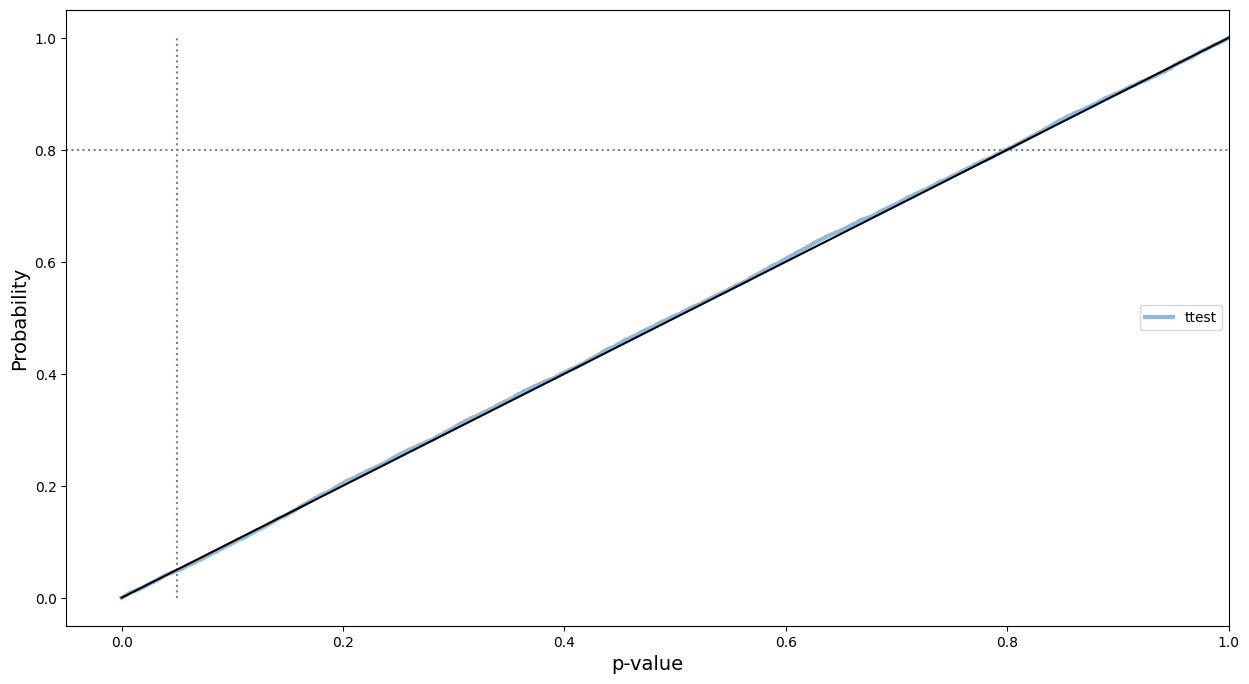

In [295]:
ttl_users = math.ceil(df_register_agg_wo_outlier['device_id'].nunique()/num_of_bucket)
effect = 0
pvalues_ttest = []
mean = []
for i in tqdm(range(10000)):
    
        df_control_wo_outlier = df_register_agg_wo_outlier.sample(n = ttl_users,replace=True)
        df_pilot_wo_outlier = df_register_agg_wo_outlier.sample(n = ttl_users,replace=True)
        df_pilot_wo_outlier['watchtime_experiment'] += effect
        means = df_pilot_wo_outlier['watchtime_experiment'].mean()
        pvalue = stats.ttest_ind(df_control_wo_outlier['watchtime_experiment'], df_pilot_wo_outlier['watchtime_experiment'])[1]
        
        pvalues_ttest.append(pvalue)
        mean.append(means)
        
list_pvalues = [pvalues_ttest]
list_titles = ['ttest']
plt.figure(figsize=(15,8))

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
x_values = [0.05/(num_of_bucket - 1)]
plt.vlines(x_values, ymin=0, ymax=1, linestyles='dotted', colors='gray')
plt.axhline(y=0.8, color='gray', linestyle='dotted')
plt.xlim([-0.05, 1])
plt.xlabel('p-value', size=14)
plt.ylabel('Probability', size=14)
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()        

In [296]:
final_table_register = []

row1 = [watchtime_control, watchtime_test_1, watchtime_ttest_control_to_test1]
row2 = [broadcast_control, broadcast_test_1, broadcast_ttest_control_to_test1]

# row3 = [watchtime_control_1_start, watchtime_test_1_start, watchtime_ttest_control_to_test1_start]
# row4 = [watchtime_control_1_stairs, watchtime_test_1_stairs, watchtime_ttest_control_to_test1_stairs]
# row5 = [watchtime_control_1_actual, watchtime_test_1_actual, watchtime_ttest_control_to_test1_actual]

row6 = [retention_1_day_control, retention_1_day_test_1, retention_1_day_ttest_control_to_test1] 
row7 = [retention_3_day_control, retention_3_day_test_1, retention_3_day_ttest_control_to_test1]

# row8 = [register_control_, register_test_1, register_test_2, register_test_3, register_ttest_control_to_test1, register_ttest_control_to_test2, register_ttest_control_to_test3]
# row9 = [watchtime_start_select_control_1, watchtime_start_test_1, watchtime_start_test_2, watchtime_start_test_3, watchtime_start_ttest_control_to_test1, watchtime_start_ttest_control_to_test2, watchtime_start_ttest_control_to_test3]


final_table_register.append(row1)
final_table_register.append(row2)
# final_table_register.append(row3)
# final_table_register.append(row4)
# final_table_register.append(row5)
final_table_register.append(row6)
final_table_register.append(row7)
# final_table_register.append(row8)
# final_table_register.append(row9)





final_table_register = pd.DataFrame(final_table_register, index=['Watchtime за 7 дней, сек','Эфир за 7 дней', 'Retention 1-го дня, %','Retention 3-го дня, %'], columns=['контроль', 'тест 1', 'тест 1 к контролю'])

final_table_register['тест 1 к контролю']=np.where(final_table_register['тест 1 к контролю'].isna(), 0, np.where(final_table_register['тест 1 к контролю']<0.05/num_of_bucket, round((final_table_register['тест 1'] / final_table_register['контроль'] - 1) * 100,2), 'Нет различия'))
# final_table_register['тест 2 к контролю']=np.where(final_table_register['тест 2 к контролю'].isna(), 0, np.where(final_table_register['тест 2 к контролю']<0.05/num_of_bucket, round((final_table_register['тест 2'] / final_table_register['контроль'] - 1) * 100,2), 'Нет различия'))
# final_table_register['тест 3 к контролю']=np.where(final_table_register['тест 3 к контролю'].isna(), 0, np.where(final_table_register['тест 3 к контролю']<0.05/num_of_bucket, round((final_table_register['тест 3'] / final_table_register['контроль'] - 1) * 100,2), 'Нет различия'))
final_table_register

,контроль,тест 1,тест 1 к контролю
"Watchtime за 7 дней, сек",87.562949,91.441588,Нет различия
Эфир за 7 дней,19.095908,21.642637,13.34
"Retention 1-го дня, %",21.245296,23.553438,Нет различия
"Retention 3-го дня, %",5.185961,7.154129,37.95


# Табличка по Зарегам (без retention)

In [297]:
final_table_register = []

row1 = [watchtime_control, watchtime_test_1, watchtime_ttest_control_to_test1]
row2 = [broadcast_control, broadcast_test_1, broadcast_ttest_control_to_test1]

# row3 = [watchtime_control_1_start, watchtime_test_1_start, watchtime_ttest_control_to_test1_start]
# row4 = [watchtime_control_1_stairs, watchtime_test_1_stairs, watchtime_ttest_control_to_test1_stairs]
# row5 = [watchtime_control_1_actual, watchtime_test_1_actual, watchtime_ttest_control_to_test1_actual]

#row6 = [retention_1_day_control, retention_1_day_test_1, retention_1_day_ttest_control_to_test1] 
#row7 = [retention_3_day_control, retention_3_day_test_1, retention_3_day_ttest_control_to_test1]

# row8 = [register_control_, register_test_1, register_test_2, register_test_3, register_ttest_control_to_test1, register_ttest_control_to_test2, register_ttest_control_to_test3]
# row9 = [watchtime_start_select_control_1, watchtime_start_test_1, watchtime_start_test_2, watchtime_start_test_3, watchtime_start_ttest_control_to_test1, watchtime_start_ttest_control_to_test2, watchtime_start_ttest_control_to_test3]


final_table_register.append(row1)
final_table_register.append(row2)
# final_table_register.append(row3)
# final_table_register.append(row4)
# final_table_register.append(row5)
#final_table_register.append(row6)
#final_table_register.append(row7)
# final_table_register.append(row8)
# final_table_register.append(row9)





final_table_register = pd.DataFrame(final_table_register, index=['Watchtime за 7 дней, сек','Эфир за 7 дней'], columns=['контроль', 'тест 1', 'тест 1 к контролю'])

final_table_register['тест 1 к контролю']=np.where(final_table_register['тест 1 к контролю'].isna(), 0, np.where(final_table_register['тест 1 к контролю']<0.05/num_of_bucket, round((final_table_register['тест 1'] / final_table_register['контроль'] - 1) * 100,2), 'Нет различия'))
# final_table_register['тест 2 к контролю']=np.where(final_table_register['тест 2 к контролю'].isna(), 0, np.where(final_table_register['тест 2 к контролю']<0.05/num_of_bucket, round((final_table_register['тест 2'] / final_table_register['контроль'] - 1) * 100,2), 'Нет различия'))
# final_table_register['тест 3 к контролю']=np.where(final_table_register['тест 3 к контролю'].isna(), 0, np.where(final_table_register['тест 3 к контролю']<0.05/num_of_bucket, round((final_table_register['тест 3'] / final_table_register['контроль'] - 1) * 100,2), 'Нет различия'))
final_table_register

,контроль,тест 1,тест 1 к контролю
"Watchtime за 7 дней, сек",87.562949,91.441588,Нет различия
Эфир за 7 дней,19.095908,21.642637,13.34


In [298]:
final_table_register['тест 1 к контролю']= np.where(final_table_register['тест 1 к контролю']=='Нет различия',final_table_register['тест 1 к контролю'], np.where(final_table_register['тест 1 к контролю'].str.contains('-'),final_table_register['тест 1 к контролю'] + '%','+' + final_table_register['тест 1 к контролю'] + '%'))


In [299]:
final_table_register[['контроль', 'тест 1','тест 1 к контролю']].style.applymap(color_cell, subset=['тест 1 к контролю'])

,контроль,тест 1,тест 1 к контролю
"Watchtime за 7 дней, сек",87.562949,91.441588,Нет различия
Эфир за 7 дней,19.095908,21.642637,+13.34%
